# Homework - Reinforcement Learning - Part B (60/100 points)


by _Todd Gureckis_ and _Brenden Lake_  
Computational Cognitive Modeling  
NYU class webpage: https://teaching.gureckislab.org/ccm


<div class="alert alert-danger" role="alert">
This homework is due according to current class website: https://teaching.gureckislab.org/ccm/
</div>


---


## Learning and deciding in an unknown world

[Part A](Homework-RL-A.ipynb) of the homework explored various solution to a
sequential decision making problem in a case where considerable information
about the environment was known or was provided (e.g., the probabilities of
transitioning between different states and the magnitude of rewards available
in particular states). However, if reinforcement learning could only be
applied to cases with full, explicit knowledge than it would be much less of a
compelling model of human learning. In many cases, humans and other animals
learn even when there is much more ambiguity, and as a result, a good model of
experiential learning for humans would apply to cases where less is known
a-priori about the world.

<img src="images/bandit.jpg" width="200">

In this part of the homework, we will shift to think about learning and
deciding in a unknown environment. This is a fairly complex topic with many
different solutions and types of problems. However, we will focus on one
particular problem class known as the **n-armed bandit**. N-armed bandits are
optimization problems that mimic many real-world problems faced by humans,
organizations, and machine learning agents. The term "bandit" comes from the
name of the casino games where you pull a lever to enter a lottery. The
bandits have one arm (the arm you pull down) and they steal your money (see
above).

<img src="images/multiarmedbandit.jpg" width="300">

An N-armed bandit is a problem where a decision maker is presented with a
bandit with $n$ arms instead of just one (see Octopus cartoon). The task for
the agent is, on each trial or moment in time, to choose bandits that are good
while avoiding those that are less good. Since nothing may be known about the
bandits a-priori, the problem is difficult and requires a balance of
_exploration_ (trying new things in order to learn) and _exploitation_
(choosing options known to be good).

If each bandit paid out a fixed amount every time it was selected, then the
problem would be solved with very simple exhaustive search process (visit each
bandit once and then select the best one for the remaining time). However, the
sequential search strategy just described doesn't capture the _opportunity
cost_ of exploration. For example, imagine that there is 100 armed bandits.
Further assume that you know that 98 give zero reward, one gives a reward of
10, and one gives a reward of 20. If on the first pull you receive 10 units of
reward then you are lucky and landed on a good one. However, is it worth going
searching for the 20 point bandit? Given that you will have to pull a lot of
zero reward bandits, it might actually be more rewarding over a finite period
to continue to pull the 10 point bandit arm. Thus, exploration and
exploitation act more like a tradeoff depending on the structure of the
problem.

In addition, when the reward received from each bandit is probabilistic or
stochastic, and furthermore the quality of the bandits might change over time,
the problem becomes much more difficult. These cases require the agent to
learn from the past but also be willing to adjust their beliefs based on more
recent information.

Bandit tasks come up in many areas of cognitive science and machine learning.
For example, there is a way to view A/B testing on websites as a
[particular type of bandit problem](https://www.amazon.com/Bandit-Algorithms-Website-Optimization-Developing/dp/1449341330)
(your goal is to ensure conversions or purchases on your website, and your
bandit arms are the different web designs you might try out). Similarly, the
very real human problem of deciding where to eat lunch is a bit like a bandit
problem -- should you return to your favorite restuarant or try a new one? Is
the exploration worth giving up a reliably good meal?

In this part of the homework you will explore different simple algorithms for
bandit problems.


### Starter code


<div class="alert alert-warning" role="alert">
  <strong>Warning!</strong> Before running other cells in this notebook you must first successfully execute the following cell which includes some libraries.
</div>


In [1]:
# The typical imports
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt 
import random
import math
import seaborn as sns

## A simple bandit environment


The first class provided here creates a set of simple, stationary multi-arm
bandits. The bandits are stateless in that the reward from choose each action
is simply a probabilistic function of the bandit itself, and there are no
other cues you can use to decide which action to take. The parameters to the
constructor of the bandit environment are:

- `mus`: the mean of the distribution from which each bandit is drawn from.
  This should have k numbers (for the k-armed bandit)
- `sds`: the standard deviation of the distribution from which the bandit
  means are drawn from (also k numbers for k bandits)


In [2]:
class KArmBanditStationary:
    def __init__(self, mus, sds):
        self.action_means = mus
        self.action_sds = sds
        self.optimal = np.argmax(self.action_means)
        self.k = len(mus)

    def step(self, action):
        return (
            np.random.normal(self.action_means[action], self.action_sds[action]),
            action == self.optimal,
        )

Your job in this first exercise is to write a simple RL agent which samples
from these bandits and attempts to earn as much reward as possible. The
following cell gives an example of how to initialize the bandit and how to
draw from it


In [3]:
bandit = KArmBanditStationary([0, 50, 10, 4], [10, 10, 10, 10])
action = 0  # pull the 0th bandit
bandit.step(
    action
)  # return values are the reward, and if the action is actually optimal or not

(5.598400862527242, False)

When we initialize the `KArmBanditStationary` we in some sense know exactly
which arm is optimal (the one with the higher mean), and also how hard the
problem is (the standard deviation of the rewards on each arm determines the
difficulty... low SD generally is a easier task due to signal-noise
relationship).


However, we are going to be implementing agents that do not have access to
this information. For example, this first cell implements a simple random
agent. You will want to modify this class to create an agent that can learn.


In [4]:
class RandomAgent:
    def __init__(self, k):
        self.num_actions = k
        # you could add parameters to your agent here
        pass

    def choose(self):
        return np.random.randint(self.num_actions)

    def learn(self, reward, action):  # this agent doesn't learn
        pass

This cell helps you plot the reward history including a smoothed average
reward earned by the agents over the last 30 trials


In [5]:
def plot_results(results_df, window=25):
    # set up figiure
    palette = iter(sns.color_palette("Set2"))
    fig = plt.figure(constrained_layout=True, figsize=(18, 5))
    gs = fig.add_gridspec(2, 5)

    # add three axes
    rew_ax = fig.add_subplot(gs[0, :-2])
    opt_ax = fig.add_subplot(gs[1, :-2])
    runs_ax = fig.add_subplot(gs[:, -2:])

    # fig, (rew_ax,opt_ax) = plt.subplots(nrows=2,ncols=1,figsize=(18,8))
    smooth_df = results_df.groupby("run").rolling(window, on="timepoint").mean()
    sns.lineplot(
        x="timepoint",
        y="reward_history",
        data=smooth_df,
        ax=rew_ax,
        label="reward",
        color=next(palette),
    )
    rew_ax.legend(loc="upper right")

    sns.lineplot(
        x="timepoint",
        y="opt",
        data=smooth_df,
        ax=opt_ax,
        label="p(optimal)",
        color=next(palette),
    )
    opt_ax.set_ylim(0, 1)
    opt_ax.legend(loc="upper right")

    sns.distplot(
        results_df.groupby("run")["opt"].mean(), ax=runs_ax, color=next(palette)
    )
    runs_ax.set_title("proportion optimal choices across runs")
    runs_ax.set_xlim(0, 1)

Finally, this is an example of the random agent's performance in the
environment.


C:\Users\liaof\AppData\Local\Temp\ipykernel_14132\1273946726.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


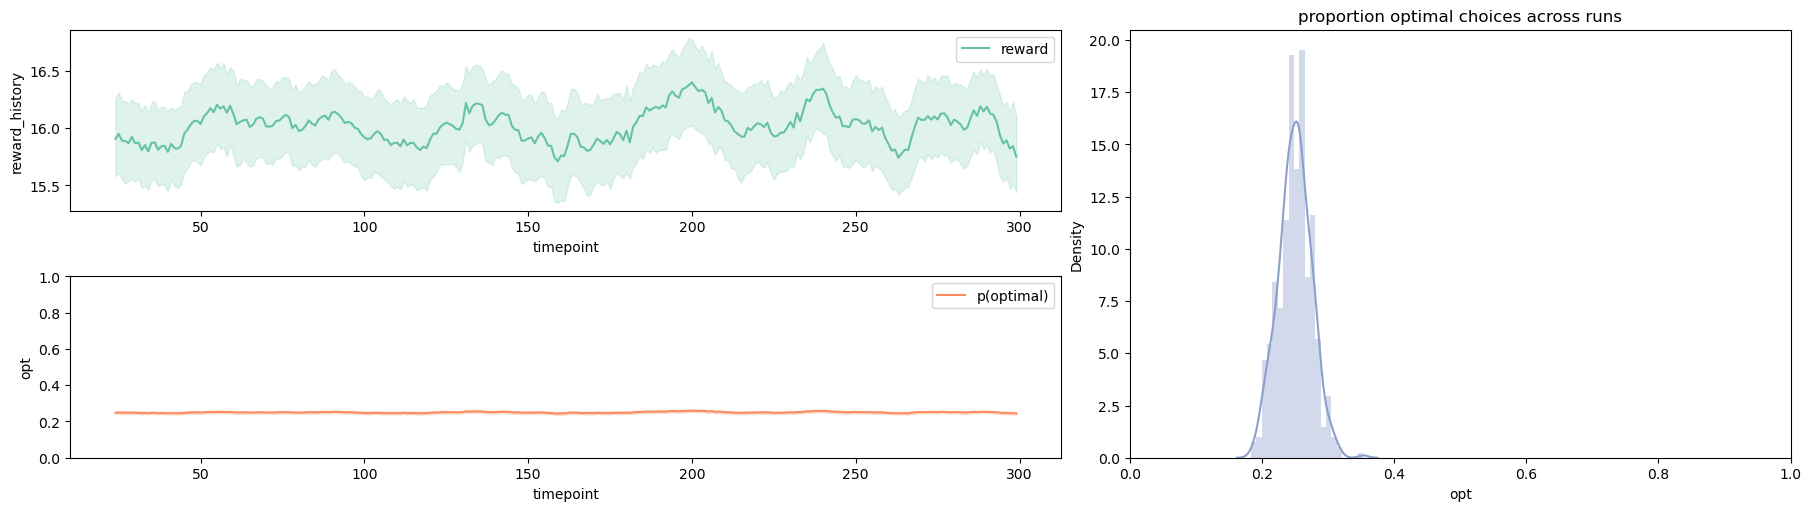

In [6]:
np.random.seed(100)  # fix a seed for repeatable experiments

# parameters of simulation
n_timesteps = 300
n_runs = 500

# set up bandit options
n_bandits = 4
bandit_means = [0, 50, 10, 4]
bandit_sds = [1] * n_bandits

reward_history = []
opt_history = []
run_history = []
timestep = []

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = RandomAgent(n_bandits)
    np.random.shuffle(bandit_means)  # randomize location of "best"
    bandit = KArmBanditStationary(bandit_means, bandit_sds)  # create a new bandit
    for i in range(n_timesteps):  # for a certain number of time steps
        choice = agent.choose()  # let the agent choose
        reward, opt = bandit.step(choice)
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)

# plot the results
sim_result_df = pd.DataFrame(
    {
        "run": run_history,
        "timepoint": timestep,
        "reward_history": reward_history,
        "opt": opt_history,
    }
)
plot_results(sim_result_df)

Here the plot shows the average reward earned for each trial of the task
across the repeated runs/experiments. The lower panel shows the proportion of
optimal choices made by the agent across trials. The error bars on both of
these plots are bootstrapped confidence intervals across runs of the agent.
Finally, the right panel shows a histogram of the proportion of optimal
choices made across the runs.

Everything looks as expected here. The random agent makes about the average
reward of the task and chooses the optimal choice about 25% of the time.

Can you use what we have learned in lecture to do better?


<div class="alert alert-success" role="alert">
<h3> Problem 4 (15 points) </h3><br>

  1. Create a new agent class based on `RandomAgent` called `EpsilonGreedyAgentIncremental()` which keeps track of the average reward earned from each draw of the bandit.  
  
  2. This agent will include a parameter `epsilon` which will determine the probability of choosing a random action, otherwise it should choose the best so far. 

  3. To update the value of each bandit use the incremental implementation of mean-tracking which was first introduced on the slides blending monte carlo methods (this is a incremental approach to calculating the mean as a new observation arrive).  

  4. Make a plot similar to the ones above showing the performance of the agent on the three measures we have considered when the environment is initialized in the same way (i.e., means are a random shuffling of [0.,50.,10.,4.] with sd=1).  

  5. Next, show with a couple examples how changes in epsilon determine the shape of that plot. 
  
  6. You should show the final code for your agent and the plots along with a single markdown cell describing your solution (1-2 paragraphs).  
  
  7. In your answer be sure to explain if your new agent does better than the random agent and why you think that is the case.  
  
 In all cases run your agent for 300 time steps and average over 500 runs.
</div>


TASK1.Create a new agent class based on `RandomAgent` called `EpsilonGreedyAgentIncremental()` which keeps track of the average reward earned from each draw of the bandit.

TASK2.This agent will include a parameter `epsilon` which will determine the probability of choosing a random action, otherwise it should choose the best so far. 

TASK3.To update the value of each bandit use the incremental implementation of mean-tracking which was first introduced on the slides blending monte carlo methods (this is a incremental approach to calculating the mean as a new observation arrive).

<div class="alert alert-info">
<h3>TASK 1&2&3 ANSWER</h3>

**See as the cell "class EpsilonGreedyAgentIncremental" below.**
</div>

TASK4.Make a plot similar to the ones above showing the performance of the agent on the three measures we have considered when the environment is initialized in the same way (i.e., means are a random shuffling of [0.,50.,10.,4.] with sd=1).

TASK5.Next, show with a couple examples how changes in epsilon determine the shape of that plot.

<div class="alert alert-info">
<h3>TASK 4&5 ANSWER</h3>

**See as the cells below, I use epslion = 0.1, 0.3 and 0.5 to calculate and plot, which shows different results. As the epsilon changes from 0.1 to 0.5, the reward plot and opt plot's upper limit become lower, and the histogram's peak become more and more left, which shows decrease of performance.**
</div>

TASK6.You should show the final code for your agent and the plots along with a single markdown cell describing your solution (1-2 paragraphs)

<div class="alert alert-info">
<h3>TASK 6 ANSWER</h3>

**See as the cells below, my EpsilonGreedyAgentIncremental will choose random bandit with probability of epsilon or otherwise choose bandit with highest average rewards in the history. And it will update and record new average rewards and numbers of trials each time it tries to get reward from the bandits.**
</div>

TASK7.In your answer be sure to explain if your new agent does better than the random agent and why you think that is the case.

<div class="alert alert-info">
<h3>TASK 7 ANSWER</h3>

As the plots below, my new agent with Epsilon-Greedy method clearly does better than the random agent, beacuse it will eventually close to p = 1-0.75*epsilon in the timepoint-opt plots, which means it will more likely to choose the optimal bandit.

Also, the reward plot shows that it will get a higher expected reward than random agent (about >16), and the reward is more stable (the shadow area is slimer).

The histogram shows can prove this solution is better too.
</div>

<div class="alert alert-warning">
<h3>My EpsilonGreedyAgentIncremental Code</h3>
</div>

In [7]:
class EpsilonGreedyAgentIncremental:
    def __init__(self, k, epsilon):
        self.num_actions = k
        # you could add parameters to your agent here
        self.epsilon = epsilon
        self.avg_rewards = np.zeros(k)
        self.n_trials = np.zeros(k)
        pass

    def choose(self):
        if random.random() < self.epsilon:
            return np.random.randint(self.num_actions)
        else:
            maxargs = np.argwhere(self.avg_rewards == np.amax(self.avg_rewards)).flatten()
            choice = np.random.choice(maxargs,1)[0]
            return choice

    def learn(self, reward, action):
        # Read History
        past_n_trials = self.n_trials[action]
        past_avg_reward = self.avg_rewards[action]
        
        # Update Record
        n_trials = past_n_trials + 1
        self.n_trials[action] = n_trials
        self.avg_rewards[action] += (reward-past_avg_reward)/n_trials

In [8]:
np.random.seed(100)  # fix a seed for repeatable experiments

# parameters of simulation
n_timesteps = 300
n_runs = 500

# set up bandit options
n_bandits = 4
bandit_means = [0, 50, 10, 4]
bandit_sds = [1] * n_bandits

<div class="alert alert-warning">
<h3>EpsilonGreedyAgentIncremental Epsilon = 0.1</h3>
</div>

C:\Users\liaof\AppData\Local\Temp\ipykernel_14132\1273946726.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


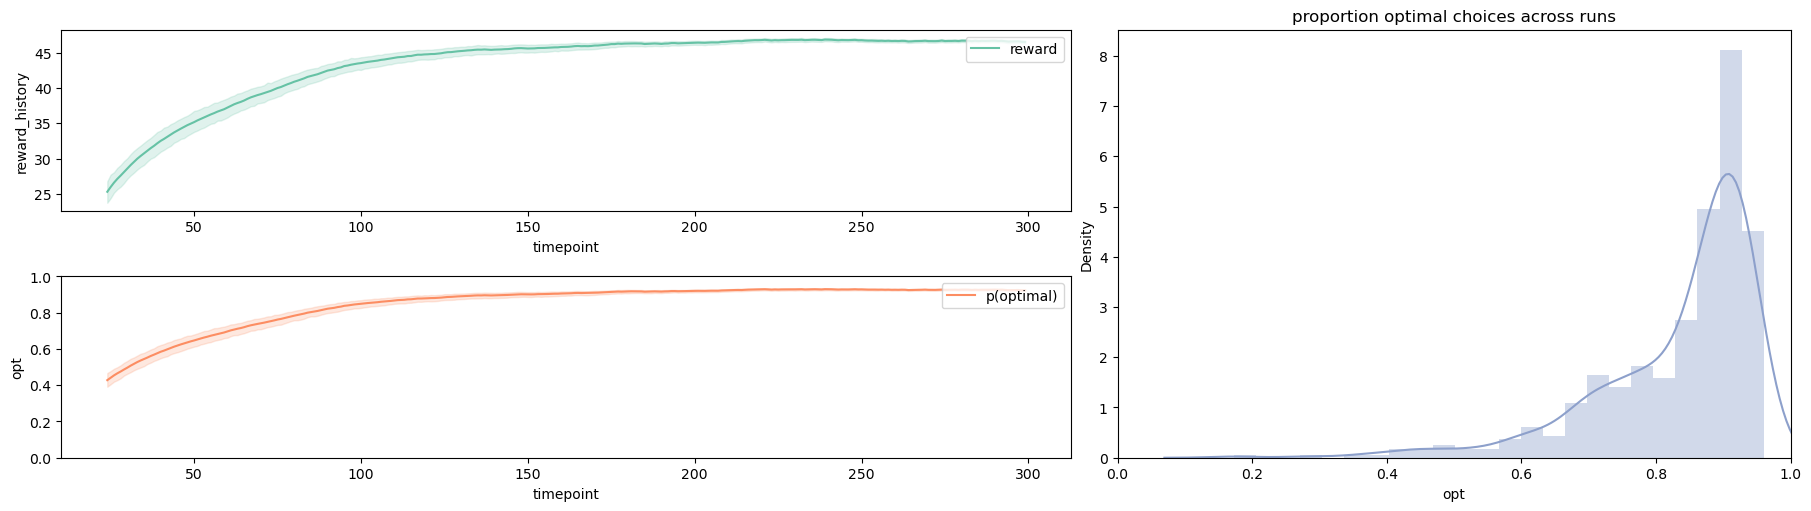

In [46]:
reward_history = []
opt_history = []
run_history = []
timestep = []

EPSILON = 0.1

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = EpsilonGreedyAgentIncremental(n_bandits, epsilon = EPSILON)
    np.random.shuffle(bandit_means)  # randomize location of "best"
    bandit = KArmBanditStationary(bandit_means, bandit_sds)  # create a new bandit
    for i in range(n_timesteps):  # for a certain number of time steps
        # Choose and Learn
        choice = agent.choose()  # let the agent choose
        reward, opt = bandit.step(choice)
        agent.learn(reward=reward, action=choice)
        
        # Record the returns
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)

# plot the results
sim_result_df = pd.DataFrame(
    {
        "run": run_history,
        "timepoint": timestep,
        "reward_history": reward_history,
        "opt": opt_history,
    }
)
plot_results(sim_result_df)

<div class="alert alert-warning">
<h3>EpsilonGreedyAgentIncremental Epsilon = 0.3</h3>
</div>

C:\Users\liaof\AppData\Local\Temp\ipykernel_23464\1273946726.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


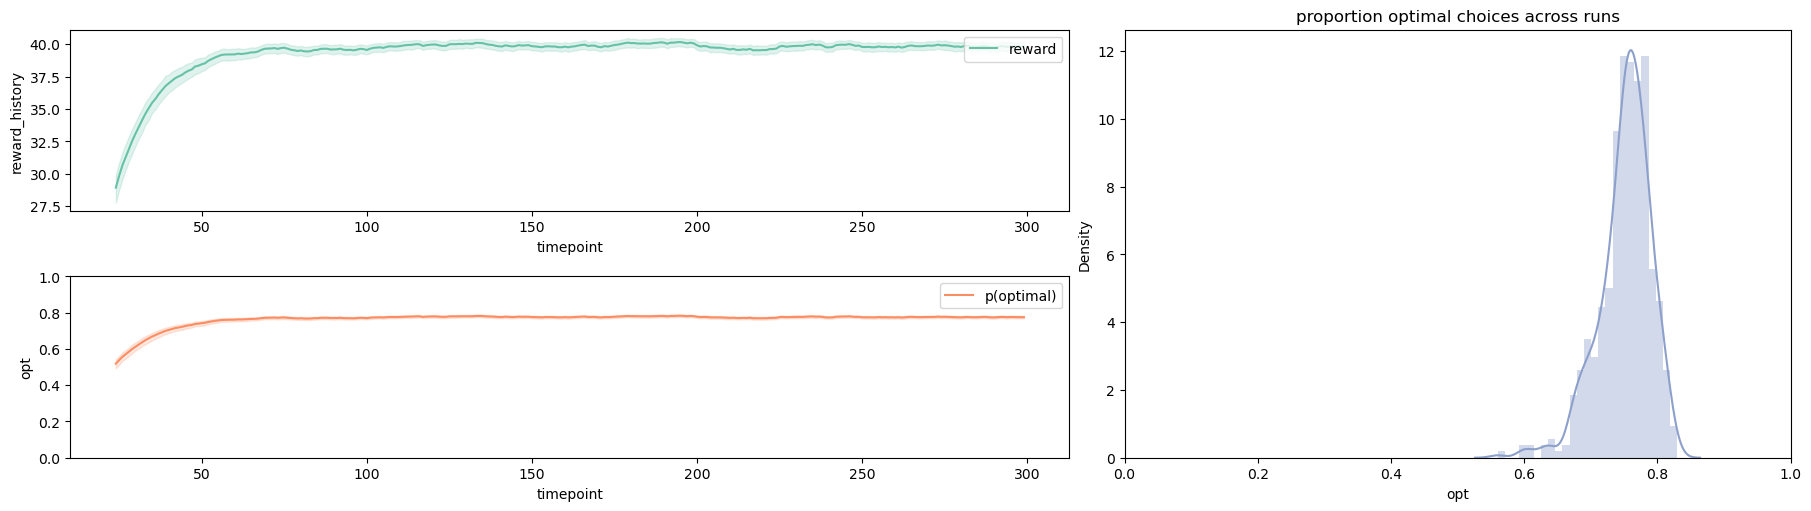

In [10]:
reward_history = []
opt_history = []
run_history = []
timestep = []

EPSILON = 0.3

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = EpsilonGreedyAgentIncremental(n_bandits, epsilon = EPSILON)
    np.random.shuffle(bandit_means)  # randomize location of "best"
    bandit = KArmBanditStationary(bandit_means, bandit_sds)  # create a new bandit
    for i in range(n_timesteps):  # for a certain number of time steps
        # Choose and Learn
        choice = agent.choose()  # let the agent choose
        reward, opt = bandit.step(choice)
        agent.learn(reward=reward, action=choice)
        
        # Record the returns
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)

# plot the results
sim_result_df = pd.DataFrame(
    {
        "run": run_history,
        "timepoint": timestep,
        "reward_history": reward_history,
        "opt": opt_history,
    }
)
plot_results(sim_result_df)

<div class="alert alert-warning">
<h3>EpsilonGreedyAgentIncremental Epsilon = 0.5</h3>
</div>

C:\Users\liaof\AppData\Local\Temp\ipykernel_23464\1273946726.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


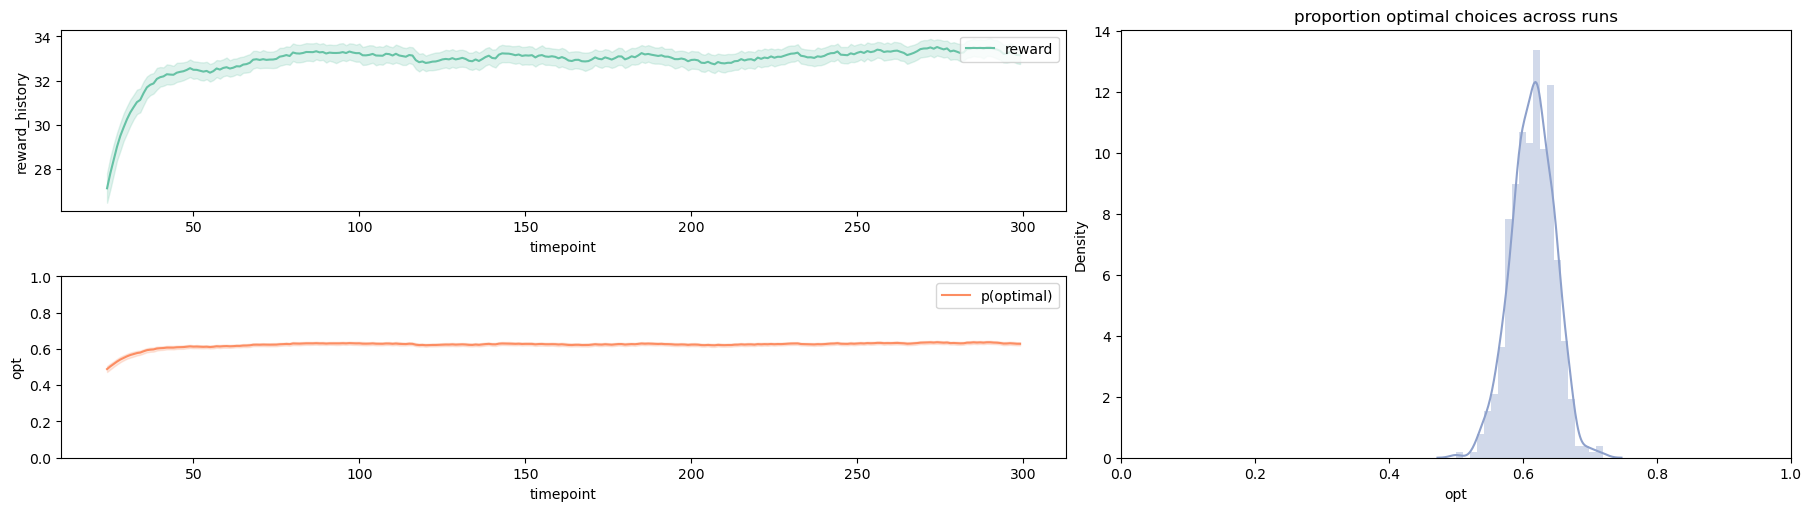

In [11]:
reward_history = []
opt_history = []
run_history = []
timestep = []

EPSILON = 0.5

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = EpsilonGreedyAgentIncremental(n_bandits, epsilon = EPSILON)
    np.random.shuffle(bandit_means)  # randomize location of "best"
    bandit = KArmBanditStationary(bandit_means, bandit_sds)  # create a new bandit
    for i in range(n_timesteps):  # for a certain number of time steps
        # Choose and Learn
        choice = agent.choose()  # let the agent choose
        reward, opt = bandit.step(choice)
        agent.learn(reward=reward, action=choice)
        
        # Record the returns
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)

# plot the results
sim_result_df = pd.DataFrame(
    {
        "run": run_history,
        "timepoint": timestep,
        "reward_history": reward_history,
        "opt": opt_history,
    }
)
plot_results(sim_result_df)

<div class="alert alert-danger">
<h3>My Exploration about the Epsilon of EpsilonGreedyAgentIncremental </h3>

Personally, I want to find how the average reward and opt at the last run change with different epsilon, and try to find the optimal epsilon $ \in [0.01, 0.5]$ with step size = 0.01. Therefore, I try the code below to search for the best epsilon $ \in [0.01, 0.5]$ with step size = 0.01 (I also print it and plot the result) and draw the reward-epsilon and opt-epsilon plot.

As the result shows, in within the range of epsilon $ \in [0.01, 0.5]$ with step size = 0.01, the optimal epsilon = 0.05, and the reward-epsilon and opt-epsilon plot both increase in [0.01, 0.05], and decrease in [0.05, 0.5].

This result is reasonable because epsilon limits the upper limit of opt value (the probability for the agent to choose the best bandit) to 1-0.75*epsilon, so epsilon need to be small enough. On the other hand, we still need enough exploration, so we still need a small epsilon. Eventually, the reward-epsilon and opt-epsilon plot both increase before 0.06, and decrease after that.

</div>

In [10]:
from tqdm import tqdm

100%|██████████| 50/50 [01:27<00:00,  1.76s/it]

Best Epsilon for EpsilonGreedyAgentIncremental:
Avg Reward:48.355369645145224
Epsilon:0.05


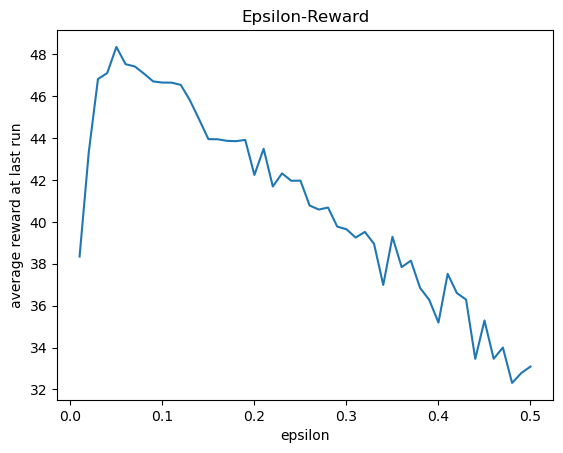

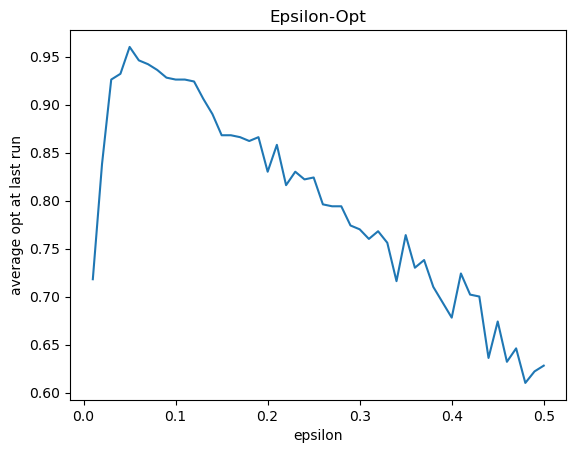

C:\Users\liaof\AppData\Local\Temp\ipykernel_14132\1273946726.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


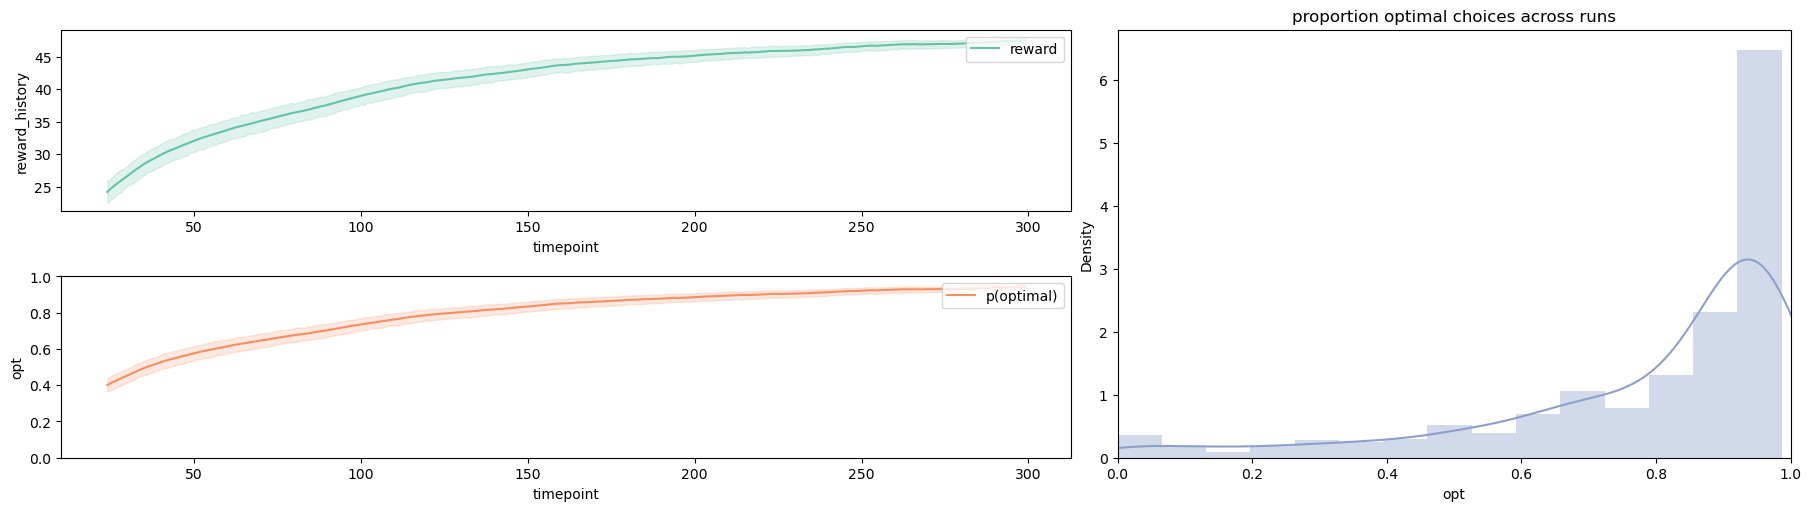

In [16]:
epsilon_step = 0.01
epsilon_arr = np.arange(0.01,0.5+epsilon_step,epsilon_step)
best_epsilon = epsilon_arr[0]
best_avg_reward = -1e5

x_epsilon_list = []
y_reward_list = []
y_opt_list = []

for epsilon in tqdm(epsilon_arr):
    cur_avg_reward = 0
    cur_avg_opt = 0
    for run in range(n_runs):  # repeat a given number random repetitions of the experiment
        agent = EpsilonGreedyAgentIncremental(n_bandits, epsilon = epsilon)
        np.random.shuffle(bandit_means)  # randomize location of "best"
        bandit = KArmBanditStationary(bandit_means, bandit_sds)  # create a new bandit
        for i in range(n_timesteps):  # for a certain number of time steps
            # Choose and Learn
            choice = agent.choose()  # let the agent choose
            reward, opt = bandit.step(choice)
            agent.learn(reward=reward, action=choice)
            
        # Record the avg returns in the last timesteps
        cur_avg_reward += (reward-cur_avg_reward)/(run+1)
        
        if opt: opt_num = 1 
        else: opt_num = 0 
        cur_avg_opt += (opt_num-cur_avg_opt)/(run+1)
    
    # record
    x_epsilon_list.append(epsilon)
    y_reward_list.append(cur_avg_reward)
    y_opt_list.append(cur_avg_opt)
    
    # update best combination
    if best_avg_reward < cur_avg_reward:
        best_avg_reward = cur_avg_reward
        best_epsilon = epsilon

print(f"Best Epsilon for EpsilonGreedyAgentIncremental:\nAvg Reward:{best_avg_reward}\nEpsilon:{best_epsilon}")
plt.figure()
x_label = "epsilon"
y_label = "average reward at last run"
title = "Epsilon-Reward"
ax = plt.axes()
ax.plot(x_epsilon_list,y_reward_list)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)
plt.show()

plt.figure()
x_label = "epsilon"
y_label = "average opt at last run"
title = "Epsilon-Opt"
ax = plt.axes()
ax.plot(x_epsilon_list,y_opt_list)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)
plt.show()

reward_history = []
opt_history = []
run_history = []
timestep = []

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = EpsilonGreedyAgentIncremental(n_bandits, epsilon = best_epsilon)
    np.random.shuffle(bandit_means)  # randomize location of "best"
    bandit = KArmBanditStationary(bandit_means, bandit_sds)  # create a new bandit
    for i in range(n_timesteps):  # for a certain number of time steps
        # Choose and Learn
        choice = agent.choose()  # let the agent choose
        reward, opt = bandit.step(choice)
        agent.learn(reward=reward, action=choice)
        
        # Record the returns
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)
# plot the results
sim_result_df = pd.DataFrame(
    {
        "run": run_history,
        "timepoint": timestep,
        "reward_history": reward_history,
        "opt": opt_history,
    }
)
plot_results(sim_result_df)

<div class="alert alert-success" role="alert">
<h3> Problem 5 (15 points) </h3><br> 

1. Create a new agent class based on `RandomAgent` called `EpsilonGreedyAgentConstant()` which keeps track of the average reward earned from each draw of the bandit.  

2. This agent will be nearly identical to `EpsilonGreedyIncremental()`.  However, in addition to the parameter `epsilon` which will determine the probability of choosing a random action, this agent should use the "constant step size" update rule related to temporal-different learning to update the value of each action.  The step size parameter (`alpha`) should be added as a new input parameter to your agent (hint: small values of this parameter are often better).   

3. Make a plot similar to the ones above showing the performance of the agent on the three measures we have considered.  

4. Is the performance of this agent the same or different than the previous agent you coded for this environment?  

5. Try a few parameter combinations with your agent and in your response show 1-2 examples to help make your point.  

6. You should show the final code for your agent and the plots along with a single markdown cell describing your solution (1-2 paragraphs). 

7. Be sure that your answer includes the answer to this key question: Does the constant agent out perform the incremental agent?  

8. And does it do better than the random agent?  (You don't need to do statistics but just a general visual comparison of the quality of the algorithsm is enough.) 

In all cases run your agent for 300 time steps and average over 500 runs.
</div>


TASK1. Create a new agent class based on `RandomAgent` called `EpsilonGreedyAgentConstant()` which keeps track of the average reward earned from each draw of the bandit.  

TASK2. This agent will be nearly identical to `EpsilonGreedyIncremental()`.  However, in addition to the parameter `epsilon` which will determine the probability of choosing a random action, this agent should use the "constant step size" update rule related to temporal-different learning to update the value of each action.  The step size parameter (`alpha`) should be added as a new input parameter to your agent (hint: small values of this parameter are often better).   

TASK3. Make a plot similar to the ones above showing the performance of the agent on the three measures we have considered.

<div class="alert alert-info">
<h3>TASK 1&2&3 ANSWER</h3>

**See as the cells below for my EpsilonGreedyAgentConstant and plots.**
</div>

TASK4.Is the performance of this agent the same or different than the previous agent you coded for this environment?

TASK5.Try a few parameter combinations with your agent and in your response show 1-2 examples to help make your point.

<div class="alert alert-info">
<h3>TASK 4&5 ANSWER</h3>

Yes, the performance of this agent is different from the previous agent.

I try epsilon-alpha combinations of 

[0.1, 0.5], [0.3, 0.5], [0.5, 0.5],

[0.1, 0.1], [0.3, 0.1], [0.5, 0.1], 

[0.1, 0.01], [0.3, 0.01], [0.5, 0.01], 

[0.1, 0.001], [0.3, 0.001], [0.5, 0.001]

and by comparing them with the previous agent with epsilon = 0.1, 0.3, 0.5, I found the following interesting conclusions:

1. As the image below, with small epilon like 0.1 (which means little exploration), if we use big alpha like 0.1 or 0.5, the result is quite similar with increamental agent with the same epilon. But if we use small alpha like 0.01 or 0.05, the performance decreased, since the shadow area in the reward plot become bigger (which means the uncertainty increased) and the histogram get two peaks instead of one (increamental agent with the same epilon and constant agent with the same epilon but use big alpha like 0.1 or 0.5 only have one obvious peak).
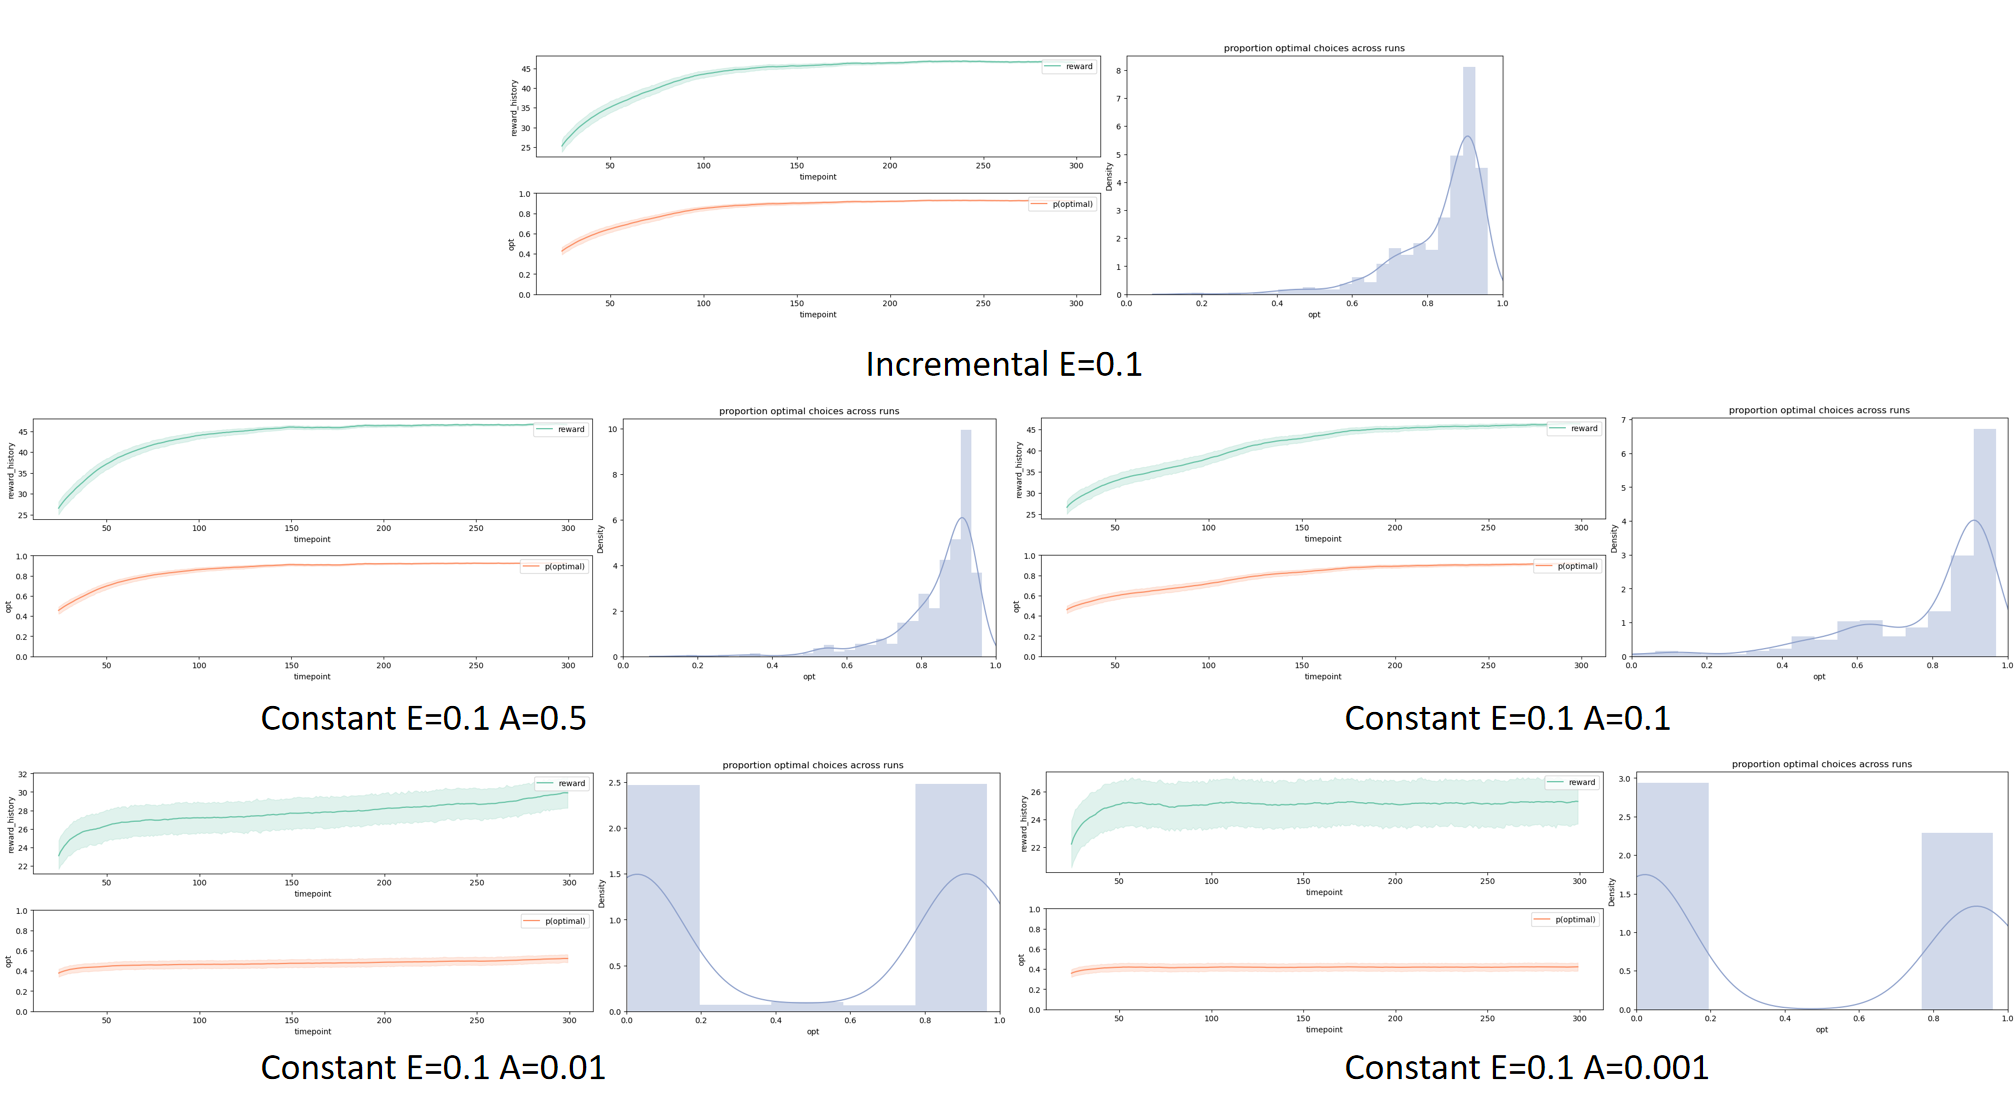

2. As the image below, with big epilon like 0.3 and 0.5 (which means more exploration, we take epilon = 0.3 as the example here), the problem of performance decrease when using smaller alpha (as we mentioned in conclusion 1) becomes less significant, as the "second peak" become lower and less obvious. But we might still use big alpha as the shadow area is smaller.
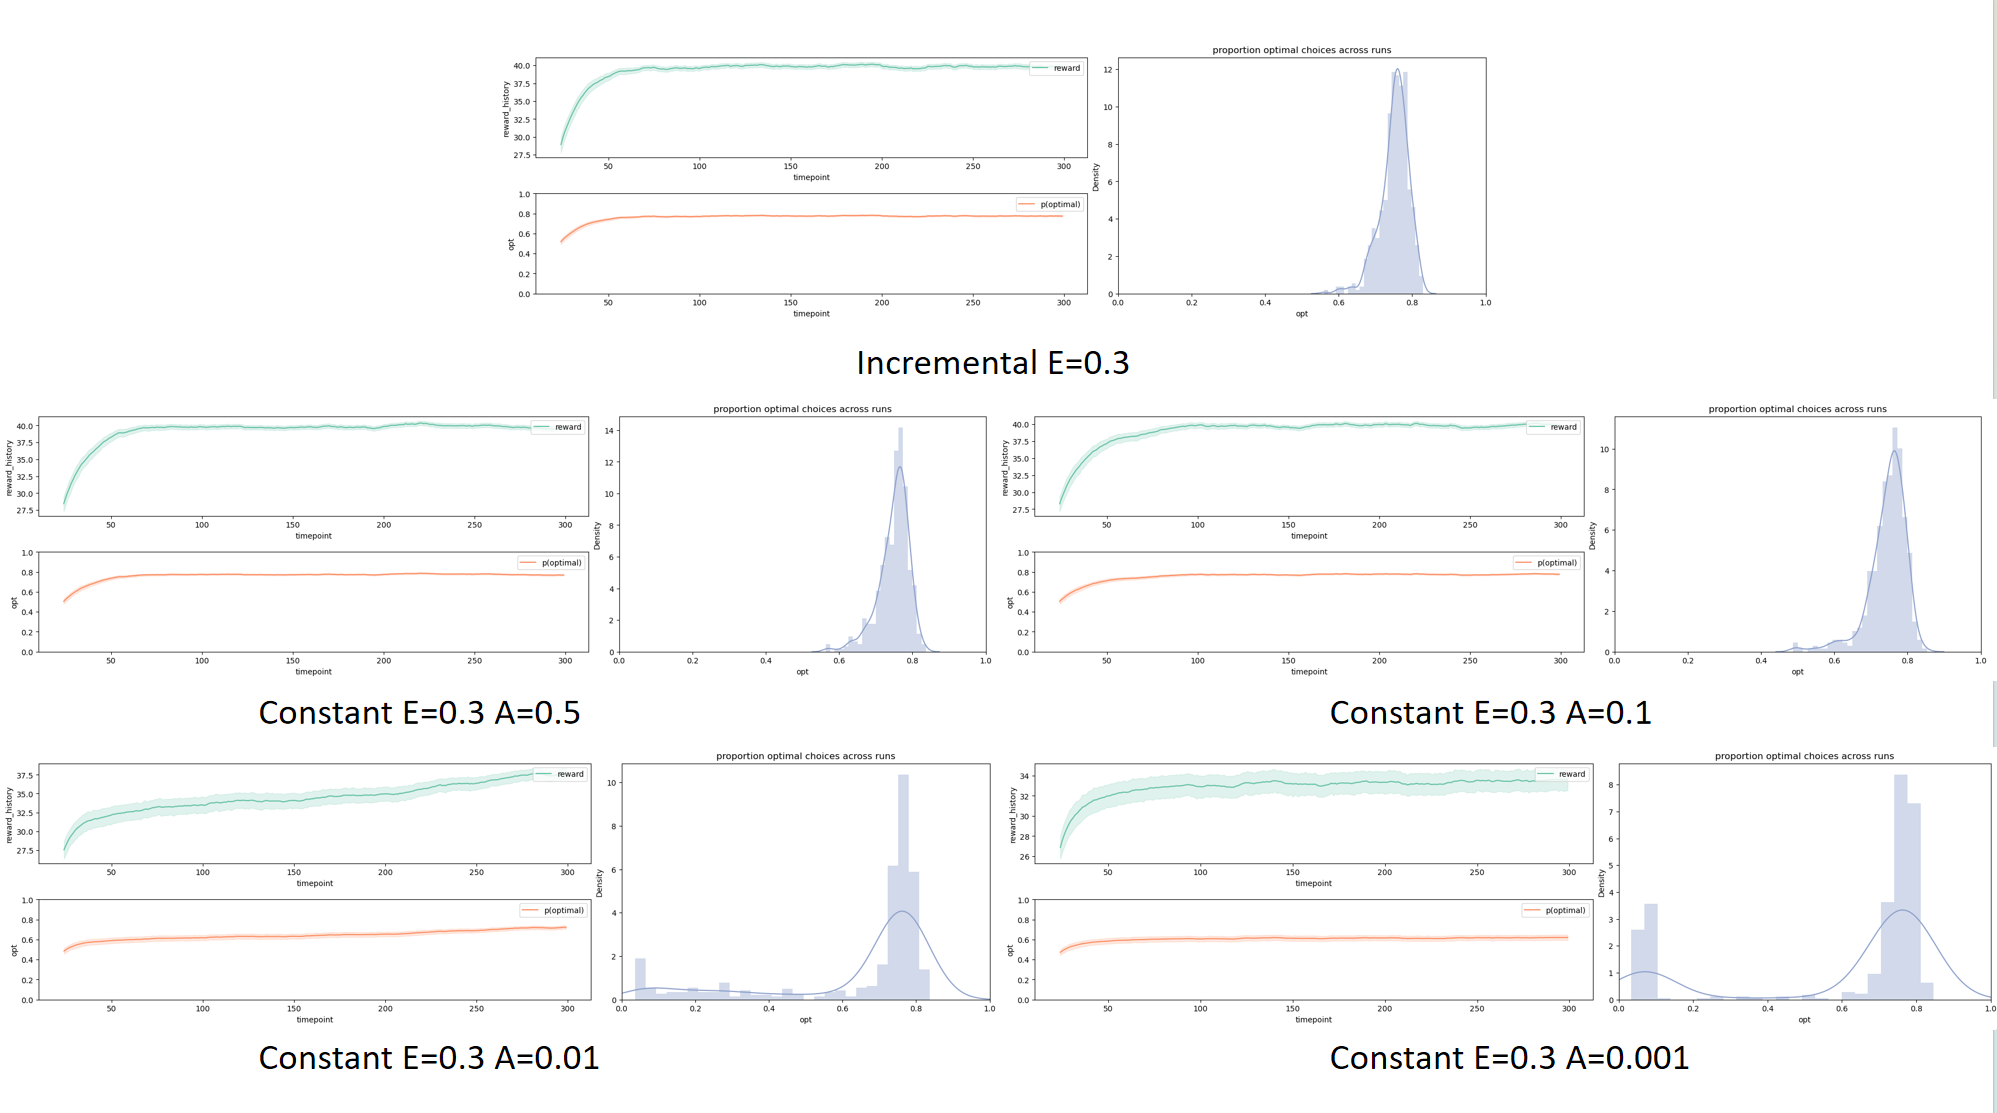

3. As the image below, under the same epilon, if we compare increamental agent and constant agent with alpha = 0.5, the latter seems to have small impovement in performance. To prove that, we need to focus on the histogram, with the same epilon, the constant agent have a higher peak with the same position on the horizontal axis. While if we compare increamental agent with constant agent with smaller alpha like 0.1, 0.01 or 0.001, the performance seems decrease. (I did not provide a image about this case here, because it is obvious)
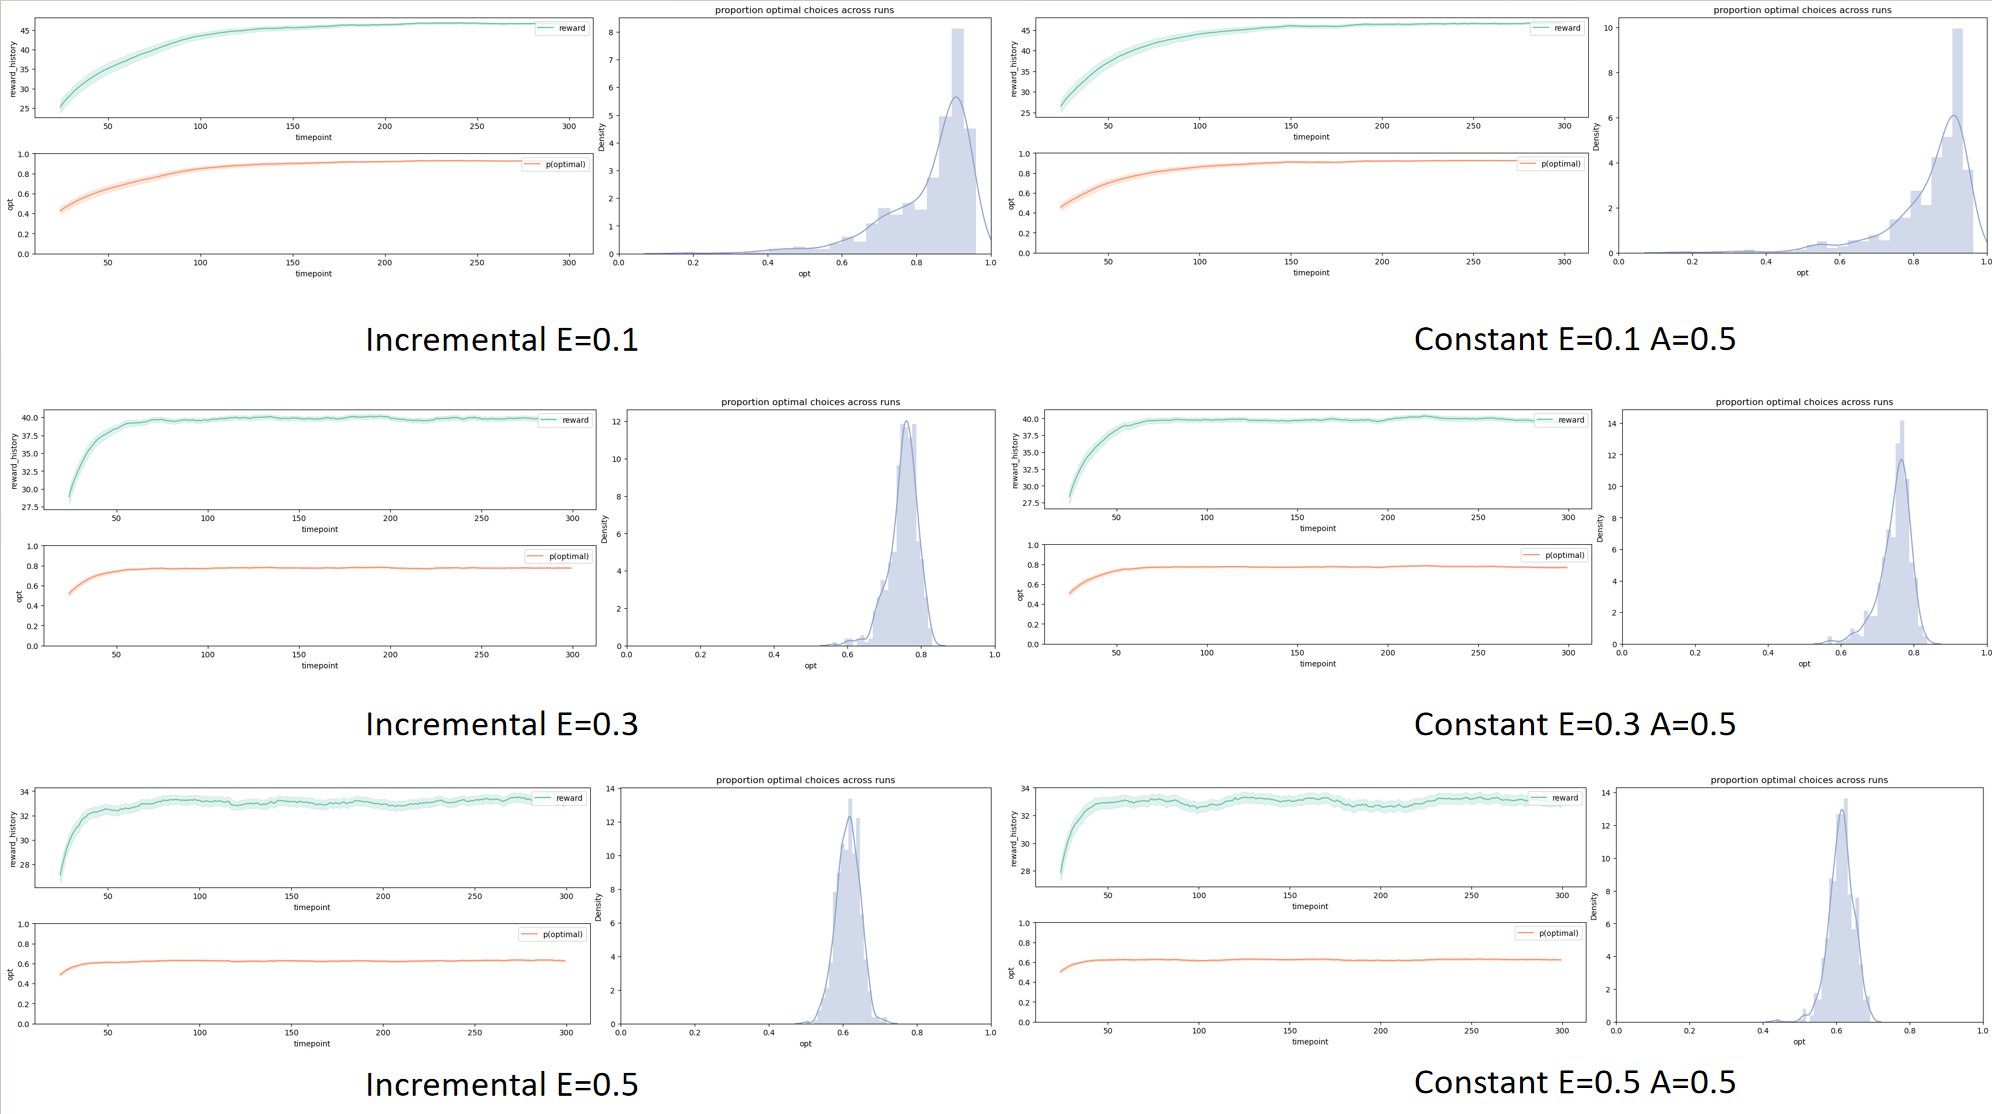

</div>

TASK6. You should show the final code for your agent and the plots along with a single markdown cell describing your solution (1-2 paragraphs).

<div class="alert alert-info">
<h3>TASK 6 ANSWER</h3>

See as the cells below for final code and plots.

My solution: Constant version of agent is quite similar with incremental version, so I simply add a new parameter ALPHA and use it to replace 1/n in the "learn" function.
</div>

TASK7. Be sure that your answer includes the answer to this key question: Does the constant agent out perform the incremental agent?  

TASK8. And does it do better than the random agent?  (You don't need to do statistics but just a general visual comparison of the quality of the algorithsm is enough.)

<div class="alert alert-info">
<h3>TASK 7&8 ANSWER</h3>

The constant agent is obvious better than the random agent as long as you choose an appropriate epsilon (like 0.1, 0.3, 0.5).

However, constant agent might not have a better performance than incremental agent. As I just shown above, only if we choose alpha big enough (like 0.5) might the constant agent out perform the incremental agent; if we choose alpha like 0.1, it might have similar performance with incremental agent; if we choose even smaller alpha like 0.01 or 0.001, it might have a worse performance. So, it depends.

</div>

<div class="alert alert-warning">
<h3>My EpsilonGreedyAgentConstant</h3>
</div>

In [18]:
class EpsilonGreedyAgentConstant:
    def __init__(self, k, epsilon, alpha):
        self.num_actions = k
        # you could add parameters to your agent here
        self.epsilon = epsilon
        self.alpha = alpha
        self.avg_rewards = np.zeros(k)
        self.n_trials = np.zeros(k)
        pass

    def choose(self):
        if random.random() < self.epsilon:
            return np.random.randint(self.num_actions)
        else:
            maxargs = np.argwhere(self.avg_rewards == np.amax(self.avg_rewards)).flatten()
            choice = np.random.choice(maxargs,1)[0]
            return choice

    def learn(self, reward, action):
        # Read History
        past_n_trials = self.n_trials[action]
        past_avg_reward = self.avg_rewards[action]
        
        # Update Record
        n_trials = past_n_trials + 1
        self.n_trials[action] = n_trials
        self.avg_rewards[action] += (reward-past_avg_reward)*self.alpha

<div class="alert alert-warning">
<h3>EpsilonGreedyAgentConstant Epsilon = 0.1, Alpha = 0.5</h3>
</div>

C:\Users\liaof\AppData\Local\Temp\ipykernel_14132\1273946726.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


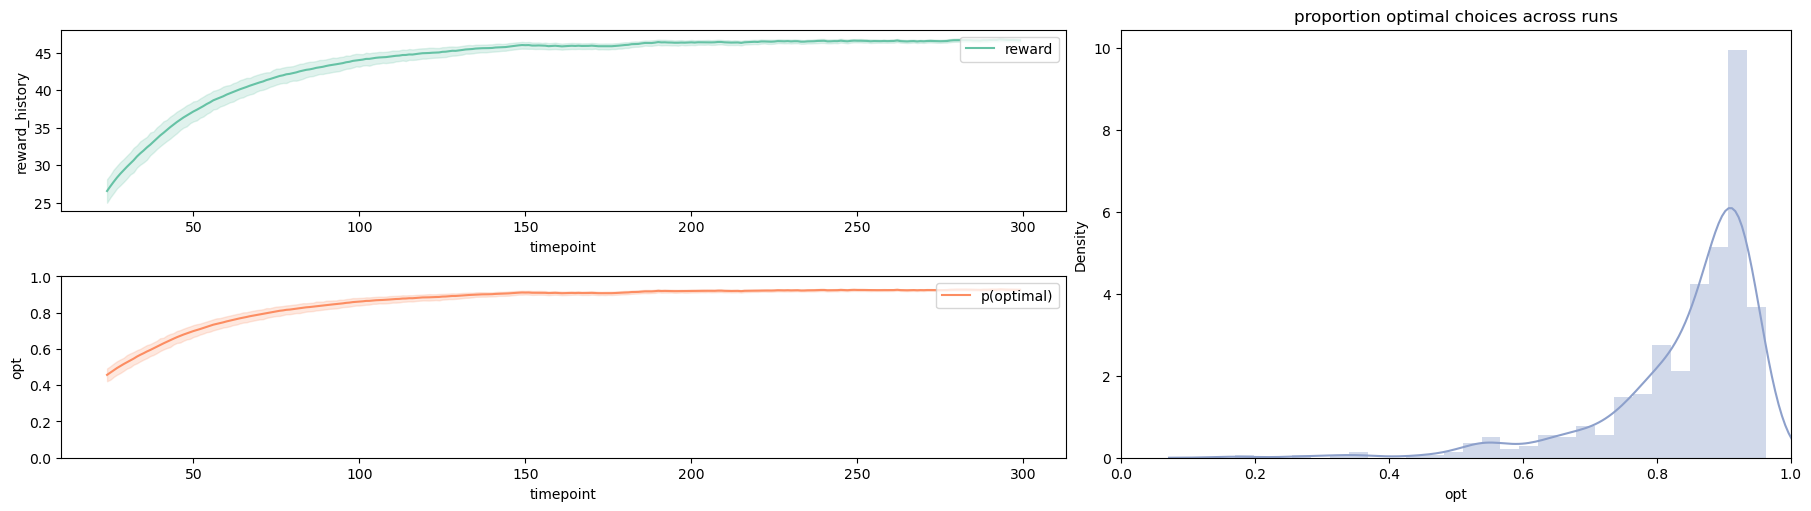

In [45]:
reward_history = []
opt_history = []
run_history = []
timestep = []

EPSILON = 0.1
ALPHA = 0.5

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = EpsilonGreedyAgentConstant(n_bandits, epsilon = EPSILON, alpha=ALPHA)
    np.random.shuffle(bandit_means)  # randomize location of "best"
    bandit = KArmBanditStationary(bandit_means, bandit_sds)  # create a new bandit
    for i in range(n_timesteps):  # for a certain number of time steps
        # Choose and Learn
        choice = agent.choose()  # let the agent choose
        reward, opt = bandit.step(choice)
        agent.learn(reward=reward, action=choice)
        
        # Record the returns
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)
# plot the results
sim_result_df = pd.DataFrame(
    {
        "run": run_history,
        "timepoint": timestep,
        "reward_history": reward_history,
        "opt": opt_history,
    }
)
plot_results(sim_result_df)

<div class="alert alert-warning">
<h3>EpsilonGreedyAgentConstant Epsilon = 0.3, Alpha = 0.5</h3>
</div>

C:\Users\liaof\AppData\Local\Temp\ipykernel_14132\1273946726.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


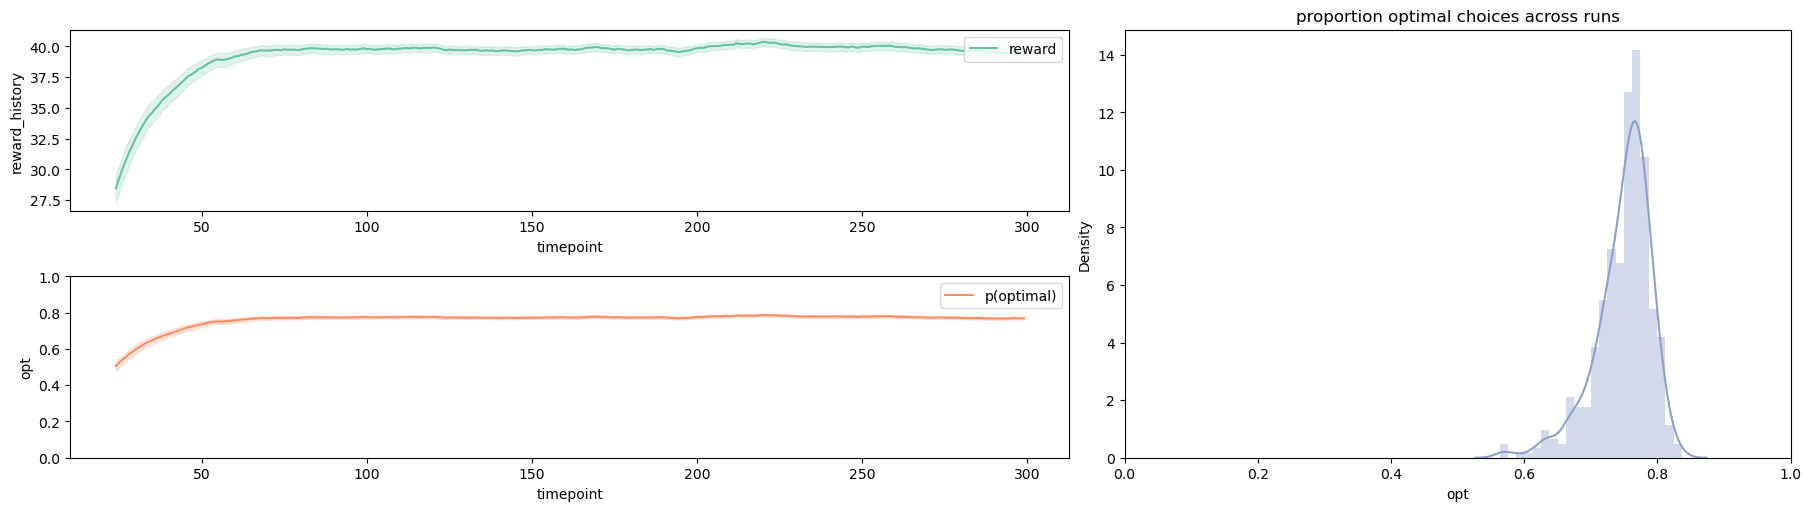

In [48]:
reward_history = []
opt_history = []
run_history = []
timestep = []

EPSILON = 0.3
ALPHA = 0.5

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = EpsilonGreedyAgentConstant(n_bandits, epsilon = EPSILON, alpha=ALPHA)
    np.random.shuffle(bandit_means)  # randomize location of "best"
    bandit = KArmBanditStationary(bandit_means, bandit_sds)  # create a new bandit
    for i in range(n_timesteps):  # for a certain number of time steps
        # Choose and Learn
        choice = agent.choose()  # let the agent choose
        reward, opt = bandit.step(choice)
        agent.learn(reward=reward, action=choice)
        
        # Record the returns
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)
# plot the results
sim_result_df = pd.DataFrame(
    {
        "run": run_history,
        "timepoint": timestep,
        "reward_history": reward_history,
        "opt": opt_history,
    }
)
plot_results(sim_result_df)

<div class="alert alert-warning">
<h3>EpsilonGreedyAgentConstant Epsilon = 0.5, Alpha = 0.5</h3>
</div>

C:\Users\liaof\AppData\Local\Temp\ipykernel_14132\1273946726.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


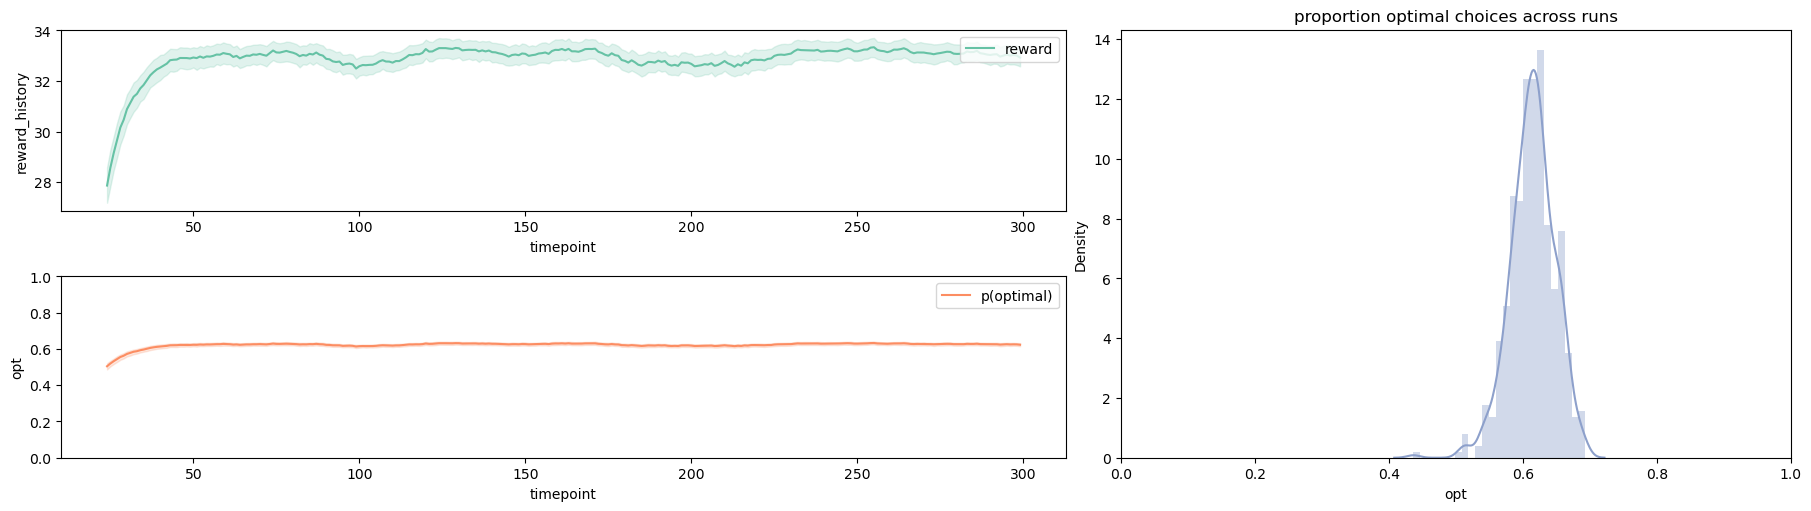

In [49]:
reward_history = []
opt_history = []
run_history = []
timestep = []

EPSILON = 0.5
ALPHA = 0.5

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = EpsilonGreedyAgentConstant(n_bandits, epsilon = EPSILON, alpha=ALPHA)
    np.random.shuffle(bandit_means)  # randomize location of "best"
    bandit = KArmBanditStationary(bandit_means, bandit_sds)  # create a new bandit
    for i in range(n_timesteps):  # for a certain number of time steps
        # Choose and Learn
        choice = agent.choose()  # let the agent choose
        reward, opt = bandit.step(choice)
        agent.learn(reward=reward, action=choice)
        
        # Record the returns
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)
# plot the results
sim_result_df = pd.DataFrame(
    {
        "run": run_history,
        "timepoint": timestep,
        "reward_history": reward_history,
        "opt": opt_history,
    }
)
plot_results(sim_result_df)

<div class="alert alert-warning">
<h3>EpsilonGreedyAgentConstant Epsilon = 0.1, Alpha = 0.1</h3>
</div>

C:\Users\liaof\AppData\Local\Temp\ipykernel_14132\1273946726.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


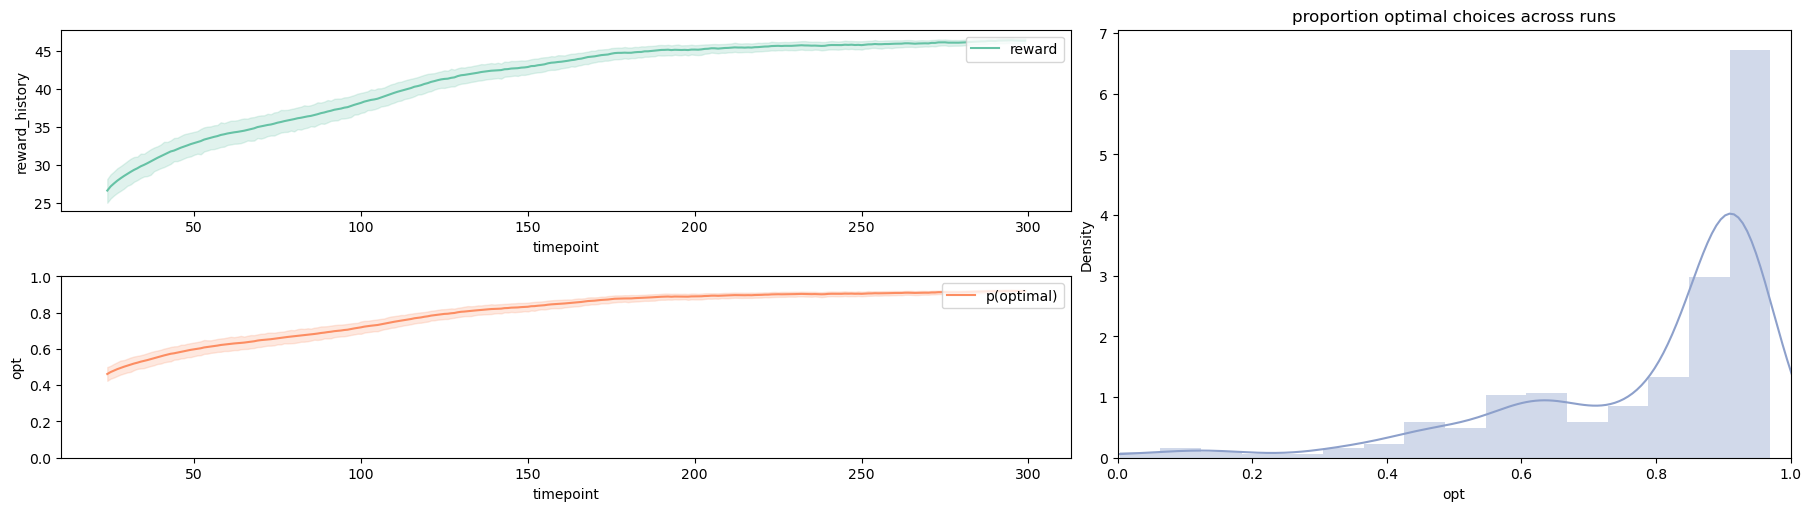

In [31]:
reward_history = []
opt_history = []
run_history = []
timestep = []

EPSILON = 0.1
ALPHA = 0.1

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = EpsilonGreedyAgentConstant(n_bandits, epsilon = EPSILON, alpha=ALPHA)
    np.random.shuffle(bandit_means)  # randomize location of "best"
    bandit = KArmBanditStationary(bandit_means, bandit_sds)  # create a new bandit
    for i in range(n_timesteps):  # for a certain number of time steps
        # Choose and Learn
        choice = agent.choose()  # let the agent choose
        reward, opt = bandit.step(choice)
        agent.learn(reward=reward, action=choice)
        
        # Record the returns
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)
# plot the results
sim_result_df = pd.DataFrame(
    {
        "run": run_history,
        "timepoint": timestep,
        "reward_history": reward_history,
        "opt": opt_history,
    }
)
plot_results(sim_result_df)

<div class="alert alert-warning">
<h3>EpsilonGreedyAgentConstant Epsilon = 0.3, Alpha = 0.1</h3>
</div>

C:\Users\liaof\AppData\Local\Temp\ipykernel_14132\1273946726.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


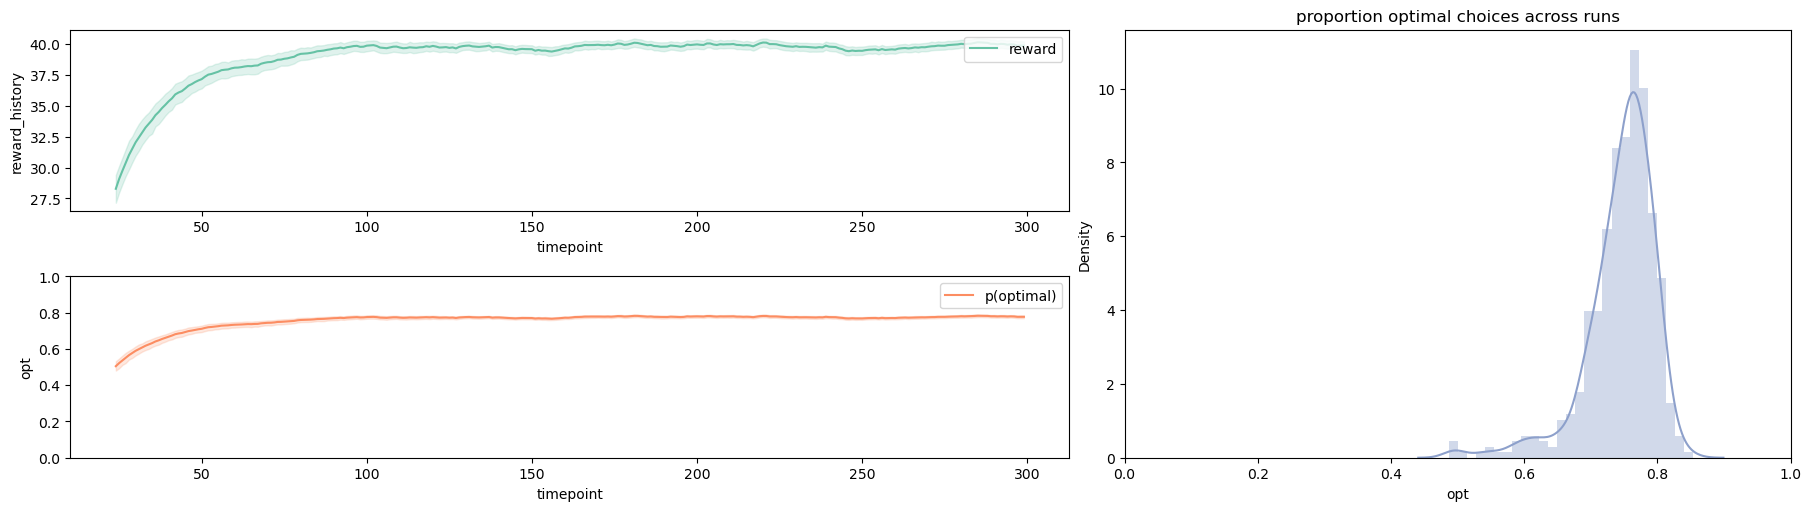

In [57]:
reward_history = []
opt_history = []
run_history = []
timestep = []

EPSILON = 0.3
ALPHA = 0.1

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = EpsilonGreedyAgentConstant(n_bandits, epsilon = EPSILON, alpha=ALPHA)
    np.random.shuffle(bandit_means)  # randomize location of "best"
    bandit = KArmBanditStationary(bandit_means, bandit_sds)  # create a new bandit
    for i in range(n_timesteps):  # for a certain number of time steps
        # Choose and Learn
        choice = agent.choose()  # let the agent choose
        reward, opt = bandit.step(choice)
        agent.learn(reward=reward, action=choice)
        
        # Record the returns
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)
# plot the results
sim_result_df = pd.DataFrame(
    {
        "run": run_history,
        "timepoint": timestep,
        "reward_history": reward_history,
        "opt": opt_history,
    }
)
plot_results(sim_result_df)

<div class="alert alert-warning">
<h3>EpsilonGreedyAgentConstant Epsilon = 0.5, Alpha = 0.1</h3>
</div>

C:\Users\liaof\AppData\Local\Temp\ipykernel_14132\1273946726.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


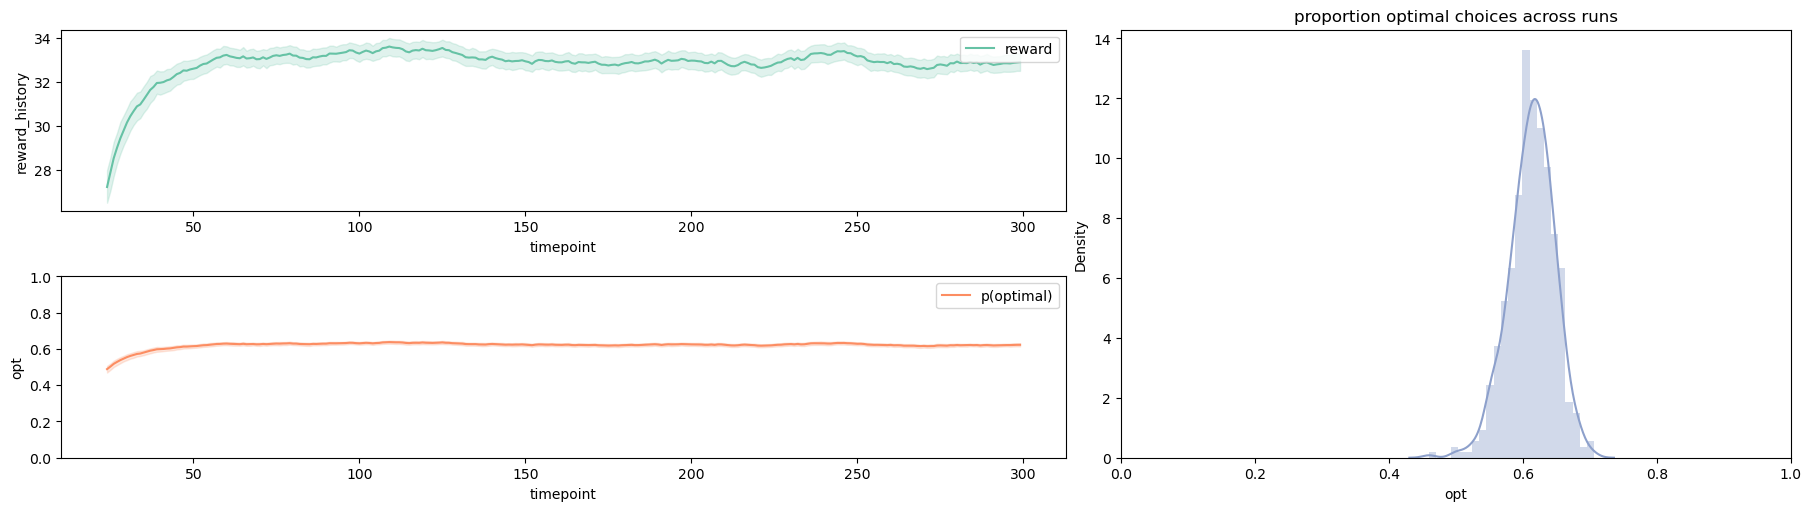

In [58]:
reward_history = []
opt_history = []
run_history = []
timestep = []

EPSILON = 0.5
ALPHA = 0.1

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = EpsilonGreedyAgentConstant(n_bandits, epsilon = EPSILON, alpha=ALPHA)
    np.random.shuffle(bandit_means)  # randomize location of "best"
    bandit = KArmBanditStationary(bandit_means, bandit_sds)  # create a new bandit
    for i in range(n_timesteps):  # for a certain number of time steps
        # Choose and Learn
        choice = agent.choose()  # let the agent choose
        reward, opt = bandit.step(choice)
        agent.learn(reward=reward, action=choice)
        
        # Record the returns
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)
# plot the results
sim_result_df = pd.DataFrame(
    {
        "run": run_history,
        "timepoint": timestep,
        "reward_history": reward_history,
        "opt": opt_history,
    }
)
plot_results(sim_result_df)

<div class="alert alert-warning">
<h3>EpsilonGreedyAgentConstant Epsilon = 0.1, Alpha = 0.01</h3>
</div>

C:\Users\liaof\AppData\Local\Temp\ipykernel_14132\1273946726.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


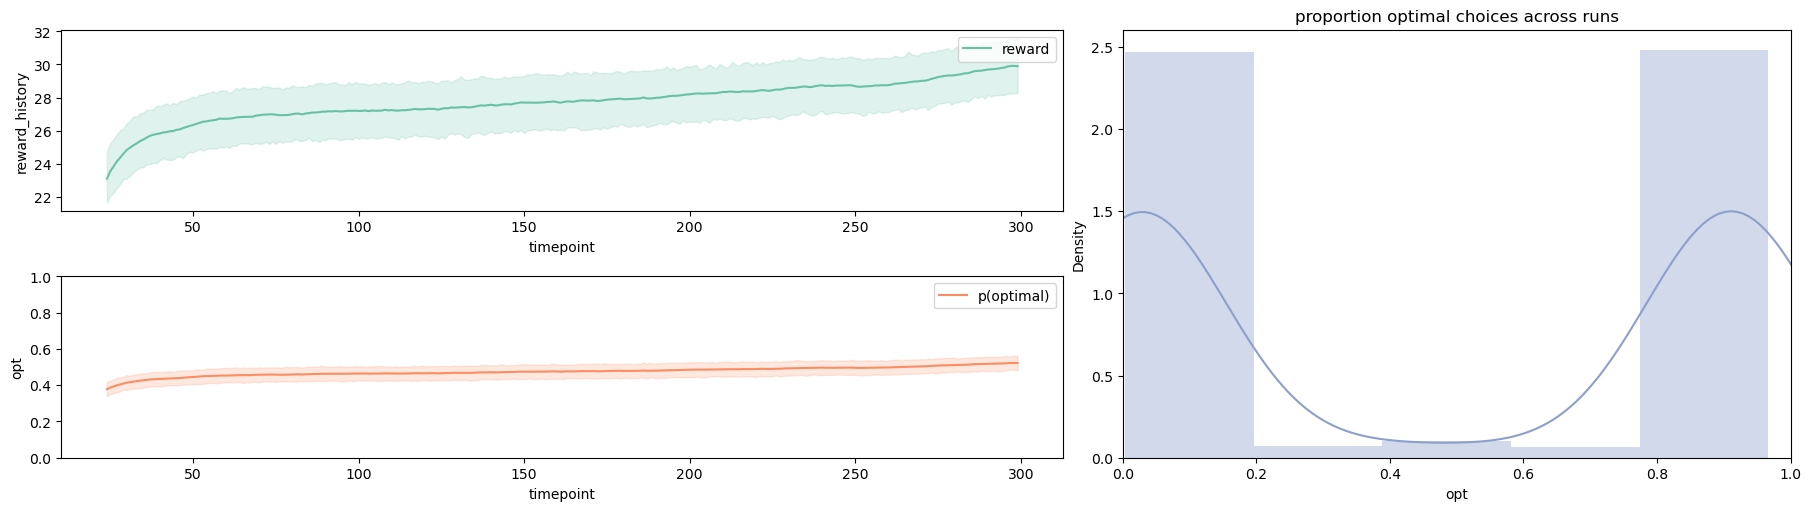

In [43]:
reward_history = []
opt_history = []
run_history = []
timestep = []

EPSILON = 0.1
ALPHA = 0.01

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = EpsilonGreedyAgentConstant(n_bandits, epsilon = EPSILON, alpha=ALPHA)
    np.random.shuffle(bandit_means)  # randomize location of "best"
    bandit = KArmBanditStationary(bandit_means, bandit_sds)  # create a new bandit
    for i in range(n_timesteps):  # for a certain number of time steps
        # Choose and Learn
        choice = agent.choose()  # let the agent choose
        reward, opt = bandit.step(choice)
        agent.learn(reward=reward, action=choice)
        
        # Record the returns
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)
# plot the results
sim_result_df = pd.DataFrame(
    {
        "run": run_history,
        "timepoint": timestep,
        "reward_history": reward_history,
        "opt": opt_history,
    }
)
plot_results(sim_result_df)

<div class="alert alert-warning">
<h3>EpsilonGreedyAgentConstant Epsilon = 0.3, Alpha = 0.01</h3>
</div>

C:\Users\liaof\AppData\Local\Temp\ipykernel_14132\1273946726.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


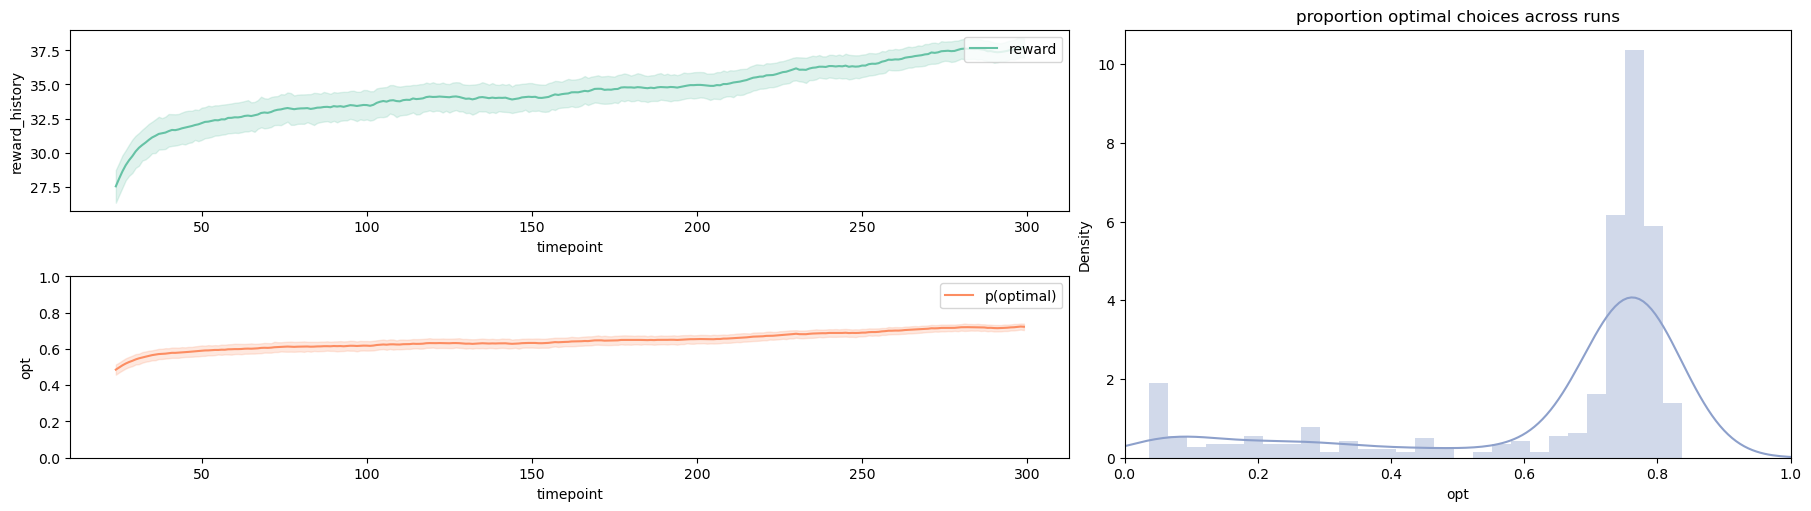

In [56]:
reward_history = []
opt_history = []
run_history = []
timestep = []

EPSILON = 0.3
ALPHA = 0.01

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = EpsilonGreedyAgentConstant(n_bandits, epsilon = EPSILON, alpha=ALPHA)
    np.random.shuffle(bandit_means)  # randomize location of "best"
    bandit = KArmBanditStationary(bandit_means, bandit_sds)  # create a new bandit
    for i in range(n_timesteps):  # for a certain number of time steps
        # Choose and Learn
        choice = agent.choose()  # let the agent choose
        reward, opt = bandit.step(choice)
        agent.learn(reward=reward, action=choice)
        
        # Record the returns
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)
# plot the results
sim_result_df = pd.DataFrame(
    {
        "run": run_history,
        "timepoint": timestep,
        "reward_history": reward_history,
        "opt": opt_history,
    }
)
plot_results(sim_result_df)

<div class="alert alert-warning">
<h3>EpsilonGreedyAgentConstant Epsilon = 0.5, Alpha = 0.01</h3>
</div>

C:\Users\liaof\AppData\Local\Temp\ipykernel_14132\1273946726.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


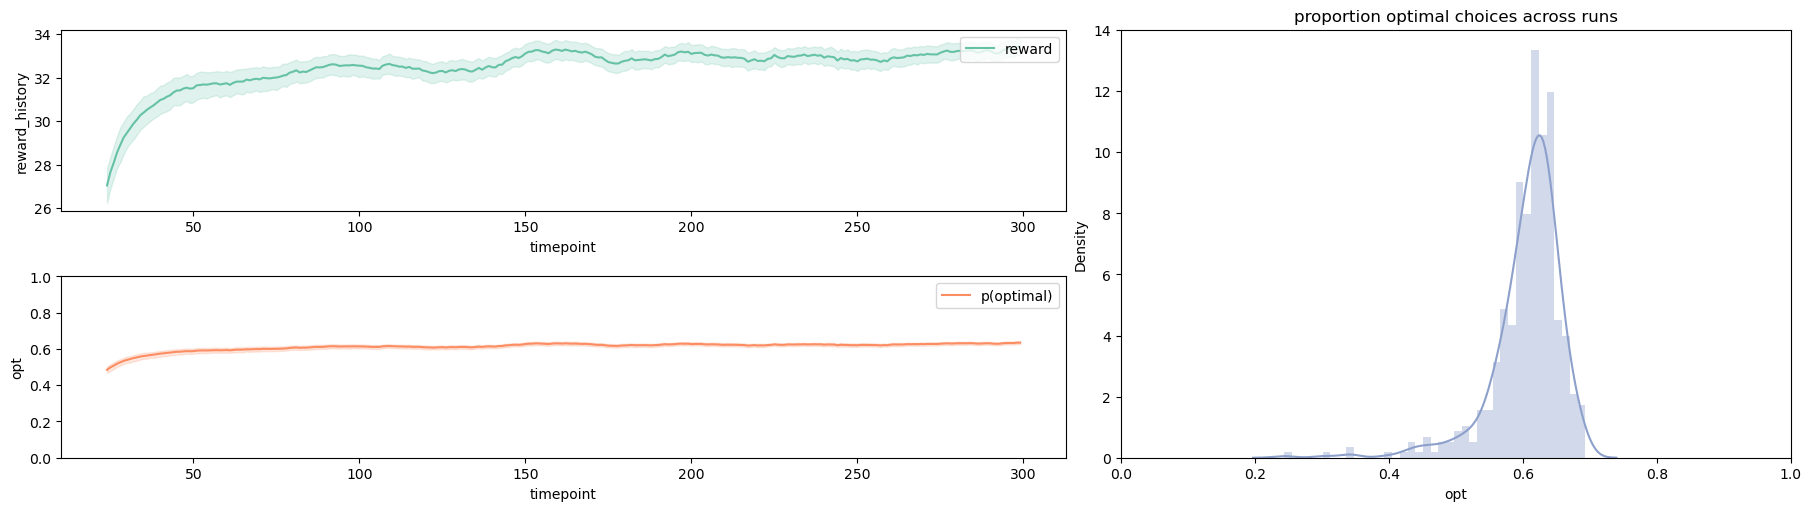

In [53]:
reward_history = []
opt_history = []
run_history = []
timestep = []

EPSILON = 0.5
ALPHA = 0.01

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = EpsilonGreedyAgentConstant(n_bandits, epsilon = EPSILON, alpha=ALPHA)
    np.random.shuffle(bandit_means)  # randomize location of "best"
    bandit = KArmBanditStationary(bandit_means, bandit_sds)  # create a new bandit
    for i in range(n_timesteps):  # for a certain number of time steps
        # Choose and Learn
        choice = agent.choose()  # let the agent choose
        reward, opt = bandit.step(choice)
        agent.learn(reward=reward, action=choice)
        
        # Record the returns
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)
# plot the results
sim_result_df = pd.DataFrame(
    {
        "run": run_history,
        "timepoint": timestep,
        "reward_history": reward_history,
        "opt": opt_history,
    }
)
plot_results(sim_result_df)

<div class="alert alert-warning">
<h3>EpsilonGreedyAgentConstant Epsilon = 0.1, Alpha = 0.001</h3>
</div>

C:\Users\liaof\AppData\Local\Temp\ipykernel_14132\1273946726.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


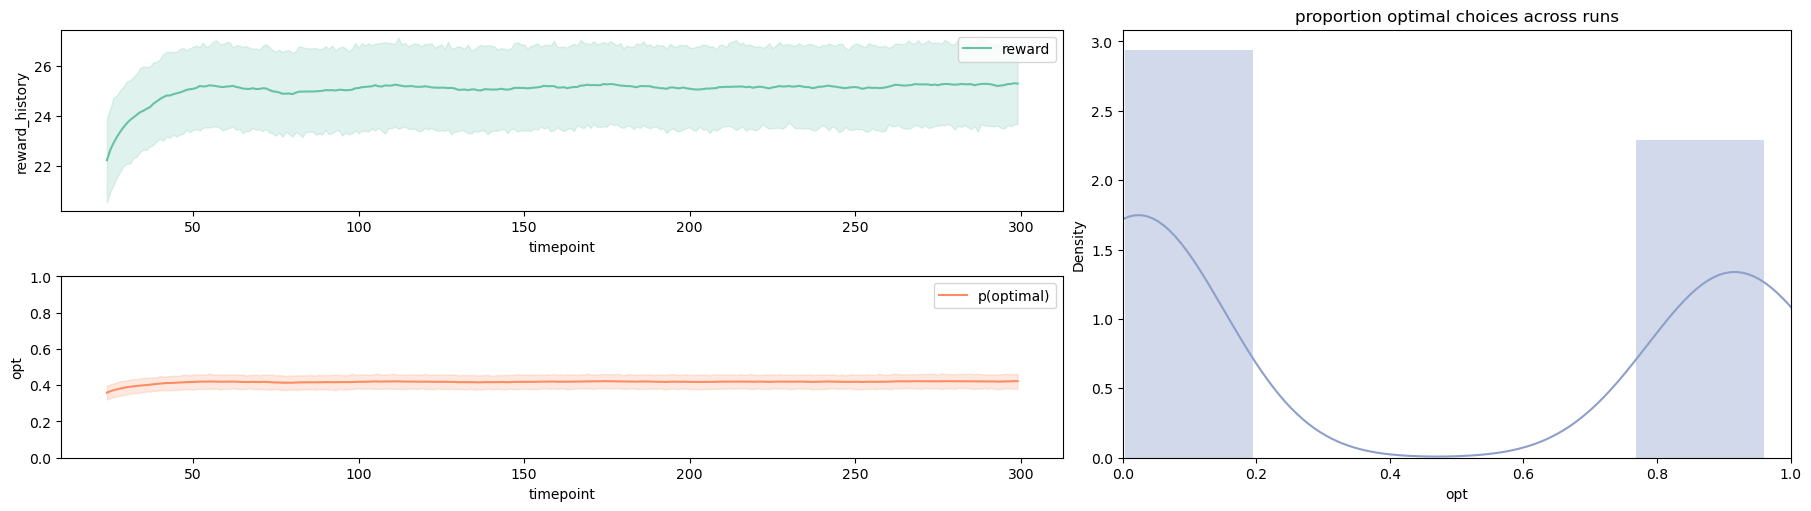

In [44]:
reward_history = []
opt_history = []
run_history = []
timestep = []

EPSILON = 0.1
ALPHA = 0.001

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = EpsilonGreedyAgentConstant(n_bandits, epsilon = EPSILON, alpha=ALPHA)
    np.random.shuffle(bandit_means)  # randomize location of "best"
    bandit = KArmBanditStationary(bandit_means, bandit_sds)  # create a new bandit
    for i in range(n_timesteps):  # for a certain number of time steps
        # Choose and Learn
        choice = agent.choose()  # let the agent choose
        reward, opt = bandit.step(choice)
        agent.learn(reward=reward, action=choice)
        
        # Record the returns
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)
# plot the results
sim_result_df = pd.DataFrame(
    {
        "run": run_history,
        "timepoint": timestep,
        "reward_history": reward_history,
        "opt": opt_history,
    }
)
plot_results(sim_result_df)

<div class="alert alert-warning">
<h3>EpsilonGreedyAgentConstant Epsilon = 0.3, Alpha = 0.001</h3>
</div>

C:\Users\liaof\AppData\Local\Temp\ipykernel_14132\1273946726.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


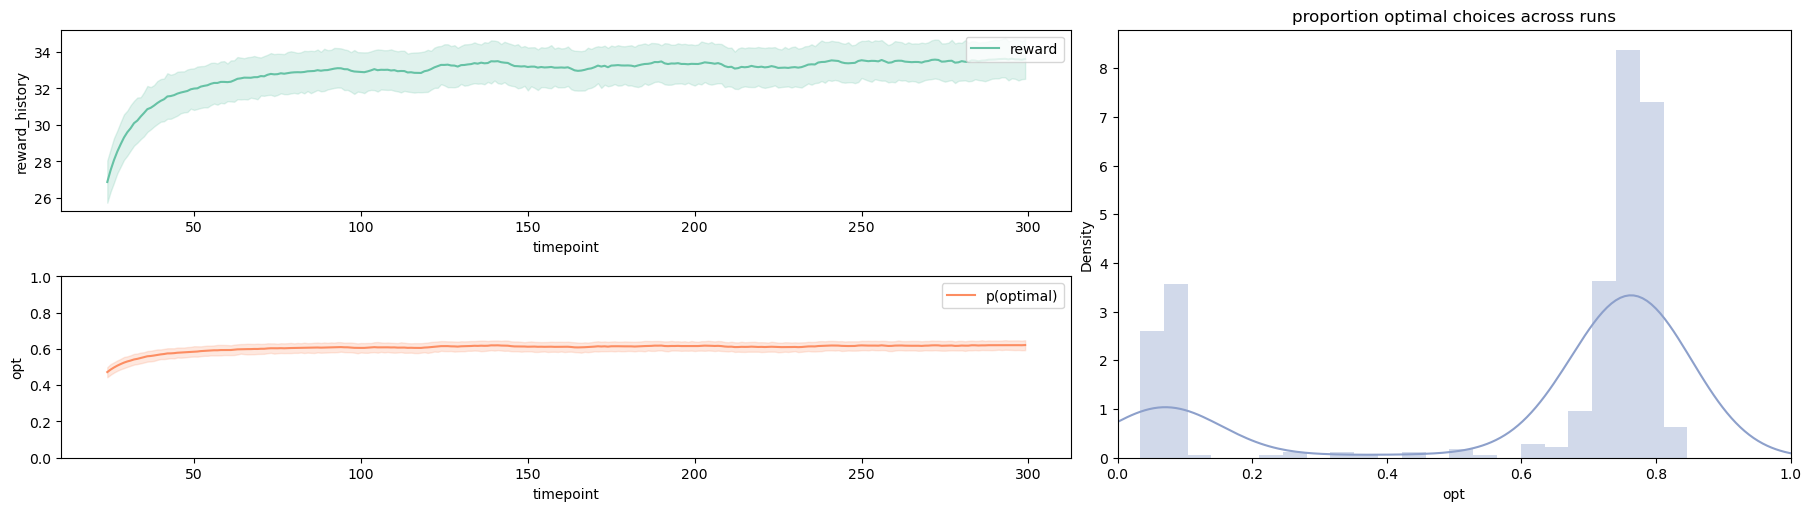

In [54]:
reward_history = []
opt_history = []
run_history = []
timestep = []

EPSILON = 0.3
ALPHA = 0.001

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = EpsilonGreedyAgentConstant(n_bandits, epsilon = EPSILON, alpha=ALPHA)
    np.random.shuffle(bandit_means)  # randomize location of "best"
    bandit = KArmBanditStationary(bandit_means, bandit_sds)  # create a new bandit
    for i in range(n_timesteps):  # for a certain number of time steps
        # Choose and Learn
        choice = agent.choose()  # let the agent choose
        reward, opt = bandit.step(choice)
        agent.learn(reward=reward, action=choice)
        
        # Record the returns
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)
# plot the results
sim_result_df = pd.DataFrame(
    {
        "run": run_history,
        "timepoint": timestep,
        "reward_history": reward_history,
        "opt": opt_history,
    }
)
plot_results(sim_result_df)

<div class="alert alert-warning">
<h3>EpsilonGreedyAgentConstant Epsilon = 0.5, Alpha = 0.001</h3>
</div>

C:\Users\liaof\AppData\Local\Temp\ipykernel_14132\1273946726.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


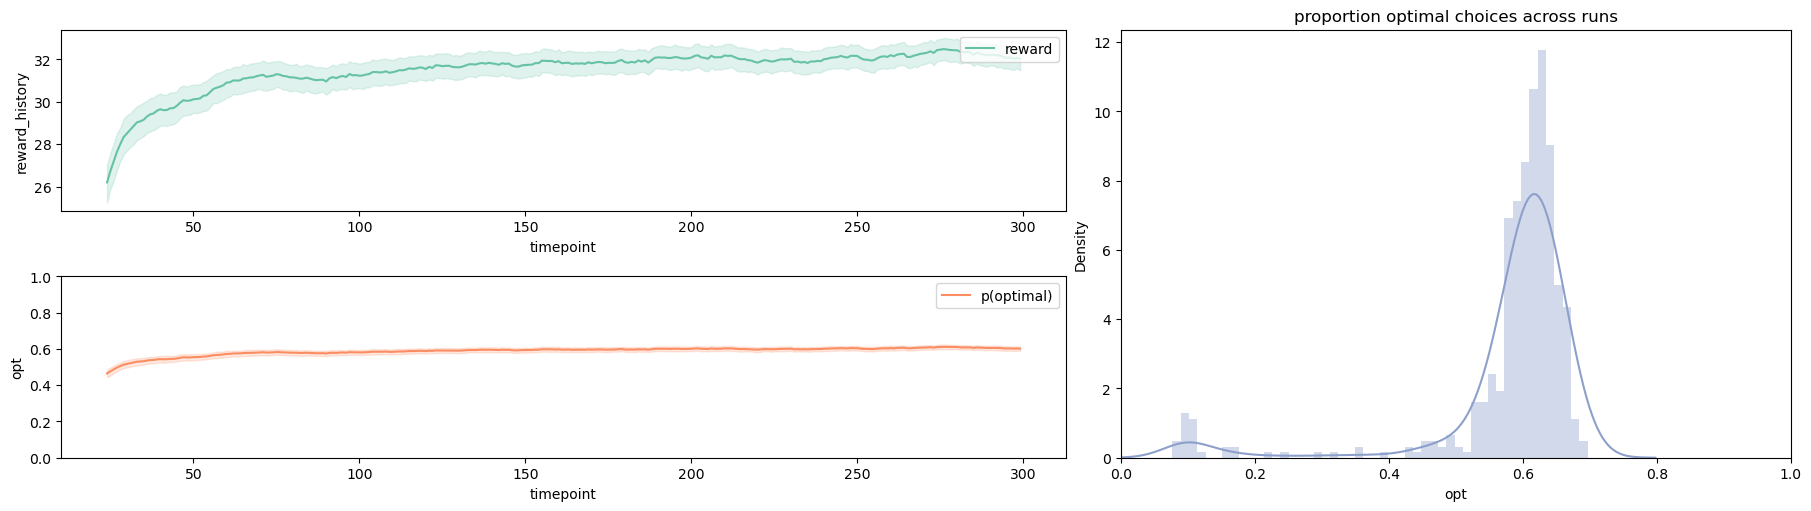

In [55]:
reward_history = []
opt_history = []
run_history = []
timestep = []

EPSILON = 0.5
ALPHA = 0.001

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = EpsilonGreedyAgentConstant(n_bandits, epsilon = EPSILON, alpha=ALPHA)
    np.random.shuffle(bandit_means)  # randomize location of "best"
    bandit = KArmBanditStationary(bandit_means, bandit_sds)  # create a new bandit
    for i in range(n_timesteps):  # for a certain number of time steps
        # Choose and Learn
        choice = agent.choose()  # let the agent choose
        reward, opt = bandit.step(choice)
        agent.learn(reward=reward, action=choice)
        
        # Record the returns
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)
# plot the results
sim_result_df = pd.DataFrame(
    {
        "run": run_history,
        "timepoint": timestep,
        "reward_history": reward_history,
        "opt": opt_history,
    }
)
plot_results(sim_result_df)

**TASK4 & TASK5 Answer:**

As I try different parameter combination (as the TASK5 asked), I found that it really hard to find the optimal combination, so I write more codes to search for the best epsilon & alpha of $\epsilon \in [0.01,0.5] (step size=0.01)$ and $\alpha \in [0.1, 1.0] (step size=0.1)$, the "best_epsilon" and "best_alpha" will get the highest average reward in the last time point. (To be fair, I also do the same thing to the EpsilonGreedyAgentIncremental, to find the best epsilon)

The performance of this agent is different than the previous agent I coded for this environment, for shadow aras is bigger, the chance to get the optimal is little lowwer than 1 - epsilon (as the result of the previous agent) and the opt-density histogram appears to have two peaks instead of one.

Also, as I try different parameter combination (as the TASK5 asked), I found that it really hard to 

<div class="alert alert-danger">
<h3>My Exploration about the Epsilon-Alpha Combination of EpsilonGreedyAgentConstant </h3>

As I did in the end of question, I try to find how average reward and opt of the last run change with epsilon-alpha combination. I take the range of epsilon $ \in [0.01, 0.4]$ with step size = 0.01, and alpha that lg(alpha)$ \in [-3, 0]$ with step size = 0.1.

</div>

100%|██████████| 40/40 [42:49<00:00, 64.23s/it] 

Best Combination for EpsilonGreedyAgentConstant:
Avg Reward:48.67968744188952
Epsilon:0.05
Alpha:0.1995262314968889



C:\Users\liaof\AppData\Local\Temp\ipykernel_14132\266260924.py:68: RuntimeWarning: divide by zero encountered in log10
  ax.plot_surface(x_epsilon_grid,y_alpha_grid,np.log10(z_reward_grid),cmap='rainbow')


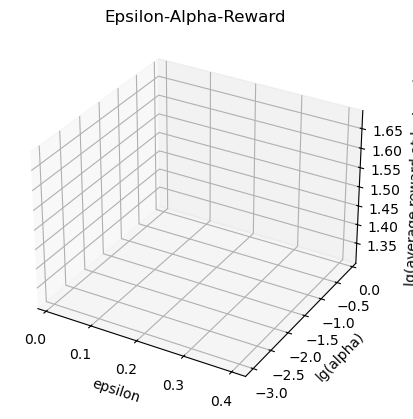

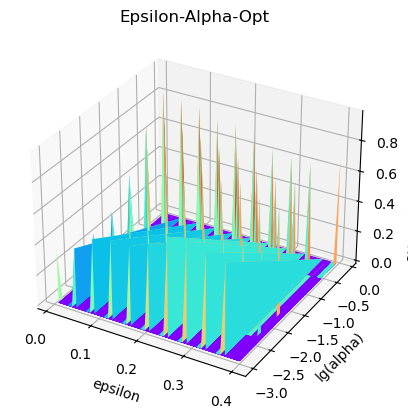

C:\Users\liaof\AppData\Local\Temp\ipykernel_14132\1273946726.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


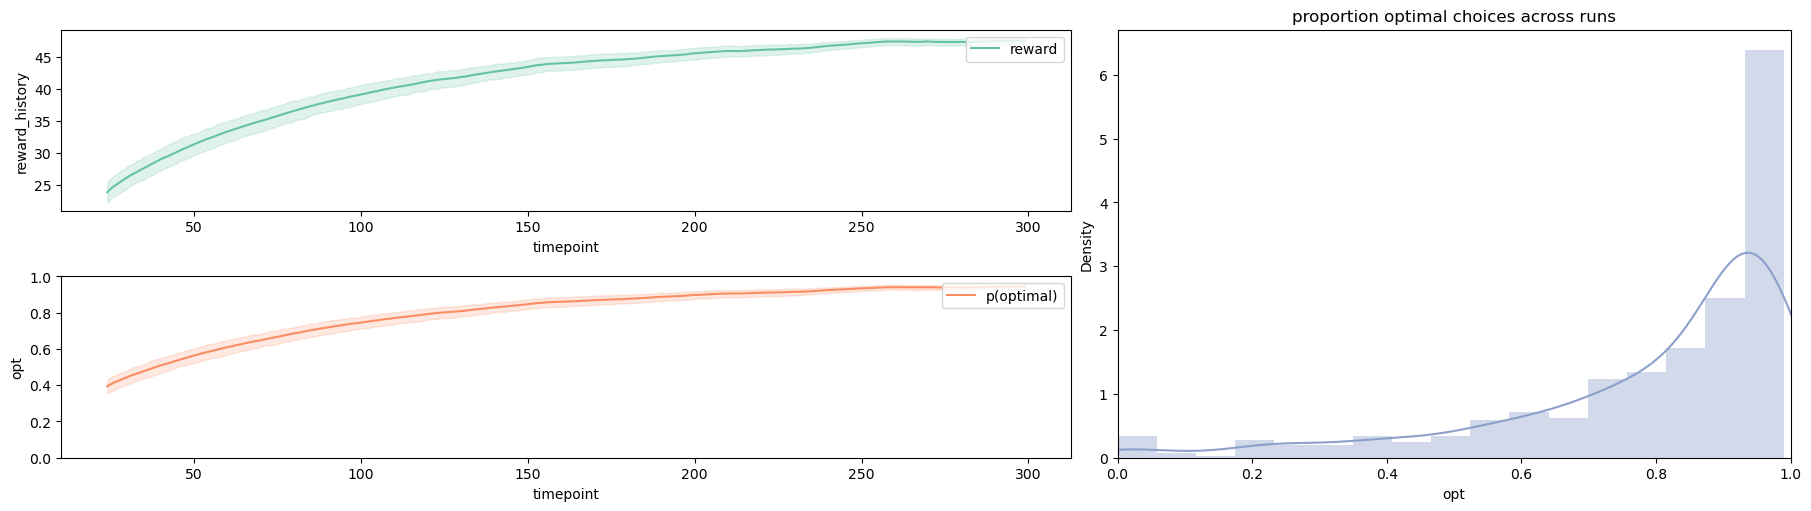

In [77]:
%matplotlib inline
epsilon_step = 0.01
lg_alpha_step = 0.1
epsilon_arr = np.arange(0.01,0.4+epsilon_step,epsilon_step)
lg_alpha_arr = np.arange(-3,0,lg_alpha_step)

best_epsilon = epsilon_arr[0]
best_alpha = 10**(lg_alpha_arr[0])
best_avg_reward = -1e5

x_epsilon_list = []
y_lg_alpha_list = []
z_reward_list = []
z_opt_list = []

for epsilon in tqdm(epsilon_arr):
    for lg_alpha in (lg_alpha_arr):
        cur_avg_reward = 0
        cur_avg_opt = 0
        for run in range(n_runs):  # repeat a given number random repetitions of the experiment
            agent = EpsilonGreedyAgentConstant(n_bandits, epsilon = epsilon, alpha=10**(lg_alpha))
            np.random.shuffle(bandit_means)  # randomize location of "best"
            bandit = KArmBanditStationary(bandit_means, bandit_sds)  # create a new bandit
            for i in range(n_timesteps):  # for a certain number of time steps
                # Choose and Learn
                choice = agent.choose()  # let the agent choose
                reward, opt = bandit.step(choice)
                agent.learn(reward=reward, action=choice)
                
            # Record the avg returns in the last timesteps
            cur_avg_reward += (reward-cur_avg_reward)/(run+1)
            if opt: opt_num = 1 
            else: opt_num = 0 
            cur_avg_opt += (opt_num-cur_avg_opt)/(run+1)
        
        # record
        x_epsilon_list.append(epsilon)
        y_lg_alpha_list.append(lg_alpha)
        z_reward_list.append(cur_avg_reward)
        z_opt_list.append(cur_avg_opt)
        
        # update best combination
        if best_avg_reward < cur_avg_reward:
            best_avg_reward = cur_avg_reward
            best_epsilon = epsilon
            best_alpha = 10**(lg_alpha)

print(f"Best Combination for EpsilonGreedyAgentConstant:\nAvg Reward:{best_avg_reward}\nEpsilon:{best_epsilon}\nAlpha:{best_alpha}")

x_epsilon_list = np.array(x_epsilon_list)
y_lg_alpha_list = np.array(y_lg_alpha_list)
z_reward_list = np.array(z_reward_list)
z_opt_list = np.array(z_opt_list)

x_epsilon_grid, y_alpha_grid = np.meshgrid(x_epsilon_list, y_lg_alpha_list)
z_reward_grid = np.empty((len(x_epsilon_list),len(y_lg_alpha_list)))
z_opt_grid = np.empty((len(x_epsilon_list),len(y_lg_alpha_list)))
for i in range(len(x_epsilon_list)):
    z_reward_grid[i][i] = z_reward_list[i]
    z_opt_grid[i][i] = z_opt_list[i]

plt.figure()
x_label = "epsilon"
y_label = "lg(alpha)"
z_label = "lg(average reward at last run)"
title = "Epsilon-Alpha-Reward"
ax = plt.axes(projection='3d')
ax.plot_surface(x_epsilon_grid,y_alpha_grid,np.log10(z_reward_grid),cmap='rainbow')
plt.xlabel(x_label)
plt.ylabel(y_label)
# plt.yscale("log")
ax.set_zlabel(z_label)
plt.title(title)
plt.show()

plt.figure()
x_label = "epsilon"
y_label = "lg(alpha)"
z_label = "average opt at last run"
title = "Epsilon-Alpha-Opt"
ax = plt.axes(projection='3d')
ax.plot_surface(x_epsilon_grid,y_alpha_grid,z_opt_grid,cmap='rainbow')
plt.xlabel(x_label)
plt.ylabel(y_label)
# plt.yscale("log")
ax.set_zlabel(z_label)
plt.title(title)
plt.show()

# plt.figure()
# x_label = "alpha"
# y_label = "average reward at last run"
# title = "Alpha-Reward"
# ax = plt.axes()
# ax.plot(y_alpha_list, z_reward_list)
# plt.xlabel(x_label)
# plt.ylabel(y_label)
# plt.title(title)
# plt.show()

# plt.figure()
# x_label = "alpha"
# y_label = "average opt at last run"
# title = "Alpha-Opt"
# ax = plt.axes()
# ax.plot(y_alpha_list,z_opt_list)
# plt.xlabel(x_label)
# plt.ylabel(y_label)
# plt.title(title)
# plt.show()


reward_history = []
opt_history = []
run_history = []
timestep = []

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = EpsilonGreedyAgentConstant(n_bandits, epsilon = best_epsilon, alpha=best_alpha)
    np.random.shuffle(bandit_means)  # randomize location of "best"
    bandit = KArmBanditStationary(bandit_means, bandit_sds)  # create a new bandit
    for i in range(n_timesteps):  # for a certain number of time steps
        # Choose and Learn
        choice = agent.choose()  # let the agent choose
        reward, opt = bandit.step(choice)
        agent.learn(reward=reward, action=choice)
        
        # Record the returns
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)
# plot the results
sim_result_df = pd.DataFrame(
    {
        "run": run_history,
        "timepoint": timestep,
        "reward_history": reward_history,
        "opt": opt_history,
    }
)
plot_results(sim_result_df)

<div class="alert alert-success" role="alert">
<h3> Problem 6 (15 points) </h3><br> 
      Below is a new type of bandit environment based on `KArmBanditStationary` class where the reward probabilities of each bandit change over time.  This is sometimes known as a "restless bandit" (see the Daw et al. 2013 paper on explore exploit mentioned in Lecture).  The idea is that on each time step the mean reward of each action should be modified up or down by a sample from a Gaussian distribution (e.g.,  $\mu_{t+1} = \mu_{t} + \mathcal{N}(0,20)$).  I have called the new class `KArmBanditRestless`.  The mean of the arms is itself drawn intiailly from a random normal distribution as well. 
      
1. Using this environment (with the number of arms set to 4), test the `RandomAgent()`, `EpsilonGreedyAgentConstant()` and `EpsilonGreedyAgentIncremental()` agents.  
      
2. You may want to play with the alpha parameter of the incremental agent to see if you can find a particularly good setting.  
      
3. Show the final code for your agent, plots showing the average reward the agent earns over time, along with a  markdown cell describing your solution in 1-2 paragraphs.  
      
4. Which agent performs better in this environment?  Is this different than the conclusion you made from the previous environment? Be sure to answer these two questions in your response.  
      
In all cases run your agent for 300 time steps and average over 500 runs.
</div>


TASK1. Using this environment (with the number of arms set to 4), test the `RandomAgent()`, `EpsilonGreedyAgentConstant()` and `EpsilonGreedyAgentIncremental()` agents. 

TASK2. You may want to play with the alpha parameter of the incremental agent to see if you can find a particularly good setting. 

<div class="alert alert-info">
<h3>TASK 1&2 ANSWER</h3>

See as the cells below for codes and plots.

When testing Constant agent, I try the same epsilon = 0.1 with different alpha = 0.5, 0.1, 0.01, 0.001, and find that when alpha = 0.01, we might get the best performance. (More details will be described in TASK4)
</div>

      
TASK3. Show the final code for your agent, plots showing the average reward the agent earns over time, along with a  markdown cell describing your solution in 1-2 paragraphs. 

<div class="alert alert-info">
<h3>TASK 3 ANSWER</h3>

See as the cells below for final code and plots.

My solution: Nothing need to be changed in agents Classes, I only copy the previous training code and replace the "np.random.shuffle(bandit_means)" and "bandit = KArmBanditStationary(bandit_means, bandit_sds)" to "bandit = KArmBanditRestless(n_bandits)"
</div>

TASK4. Which agent performs better in this environment?  Is this different than the conclusion you made from the previous environment? Be sure to answer these two questions in your response.  

<div class="alert alert-info">
<h3>TASK 4 ANSWER</h3>

As the image below, the constant agent have better performance in this environment. And there are some difference compare with the conclusion made from the previous environment:

1. In previous conclusion, when we use small epsilon = 0.1, the smaller alpha like 0.01 and 0.001 will significantly decrease the performance. However, in this case, the combination of epsilon=0.1 and alpha = 0.01 is the best one (becasue it have the sharpest and highest peak in histogram and highest average reward in reward plot), and when we use alpha=0.001, the performance doesn't decrease a lot.
2. In previous conclusion, we found that only when we use alpha=0.5, the constant agent will out perform incremental agent, but in this case, all alpha = 0.5, 0.1, 0.01, 0.001 version of constant agent have a better performance than incremental agent. (as the histogram shown)
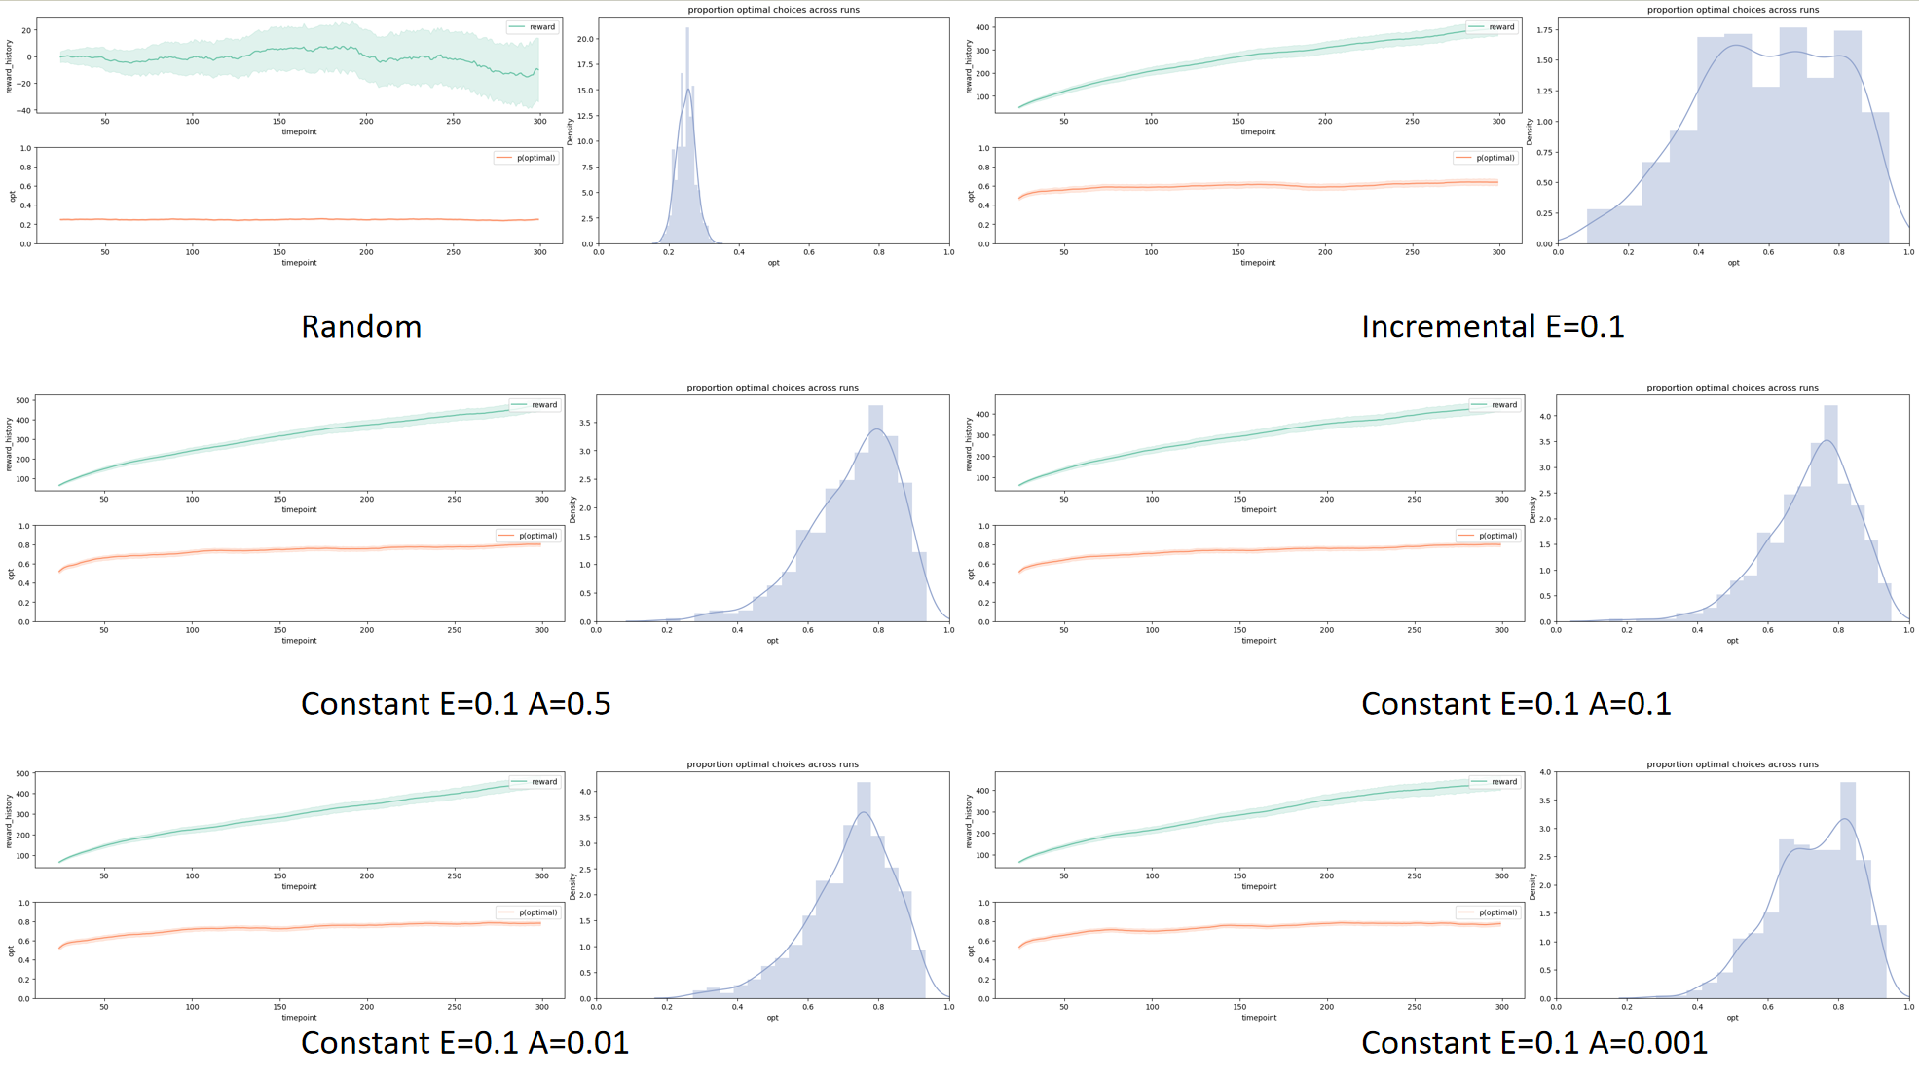
</div>

In [60]:
class KArmBanditRestless:
    def __init__(self, k, mu=0, sigma=2, sd=2, walk_sd=30):
        self.k = k
        self.action_means = np.random.normal(mu, sigma, k)
        self.action_sds = sd
        self.walk_sd = walk_sd
        self.optimal = np.argmax(self.action_means)

    def step(self, action):
        out = (
            np.random.normal(self.action_means[action], self.action_sds),
            action == self.optimal,
        )
        self.action_means = self.action_means + np.random.normal(
            0.0, self.walk_sd, self.k
        )
        self.optimal = np.argmax(self.action_means)
        return out

In [17]:
# intialize this bandit like this
n_bandits = 4
bandit = KArmBanditRestless(n_bandits)

<div class="alert alert-warning">
<h3>RandomAgentConstant on Restless Bandit</h3>
</div>

C:\Users\liaof\AppData\Local\Temp\ipykernel_23464\1273946726.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


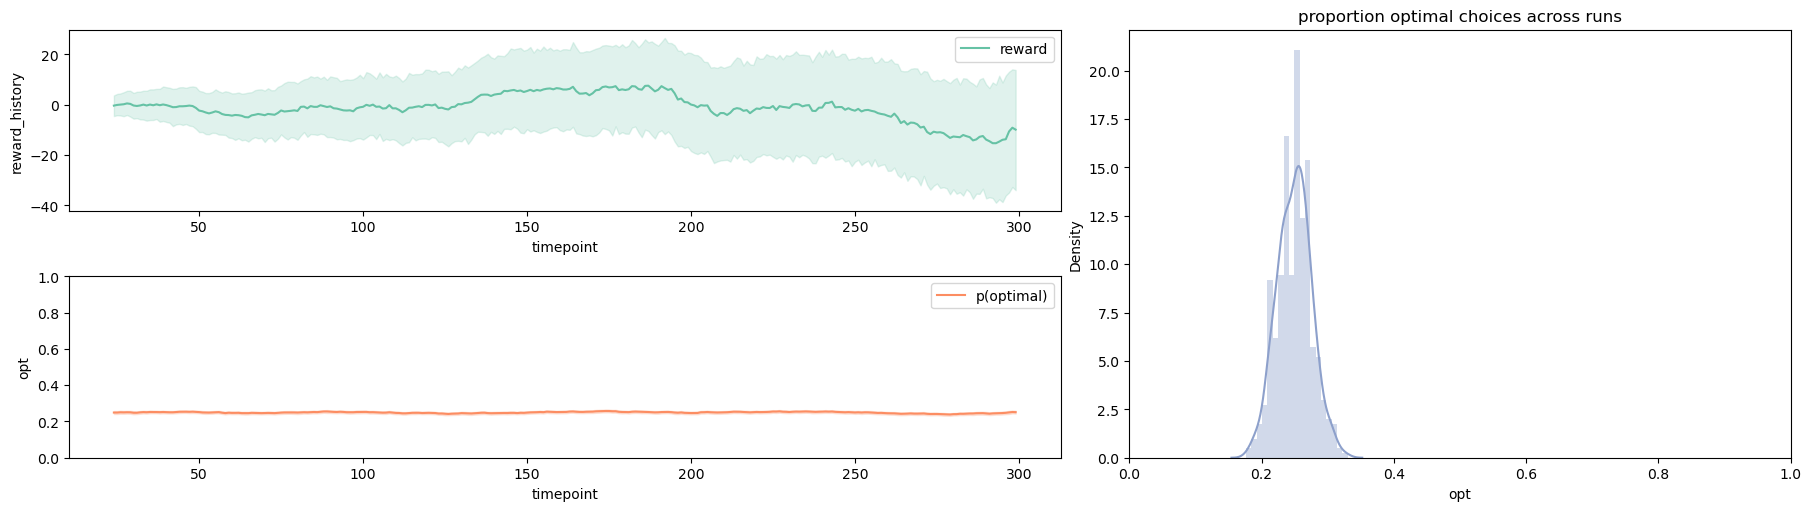

In [21]:
reward_history = []
opt_history = []
run_history = []
timestep = []

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = RandomAgent(n_bandits)
    bandit = KArmBanditRestless(n_bandits)
    for i in range(n_timesteps):  # for a certain number of time steps
        choice = agent.choose()  # let the agent choose
        reward, opt = bandit.step(choice)
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)

# plot the results
sim_result_df = pd.DataFrame(
    {
        "run": run_history,
        "timepoint": timestep,
        "reward_history": reward_history,
        "opt": opt_history,
    }
)
plot_results(sim_result_df)

<div class="alert alert-warning">
<h3>EpsilonGreedyAgentIncremental with Epsilon=0.1 on Restless Bandit</h3>
</div>

C:\Users\liaof\AppData\Local\Temp\ipykernel_14132\1273946726.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


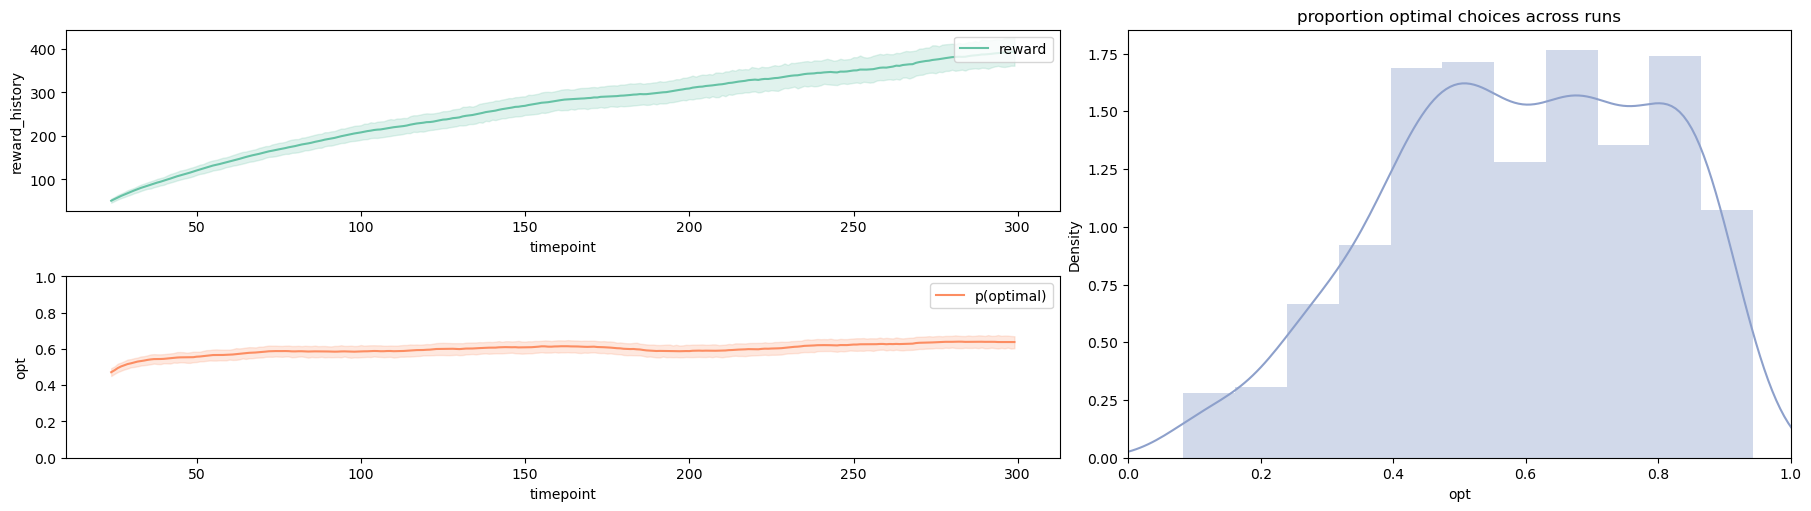

In [61]:
EPSILON = 0.1

reward_history = []
opt_history = []
run_history = []
timestep = []

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = EpsilonGreedyAgentIncremental(n_bandits, epsilon = EPSILON)
    bandit = KArmBanditRestless(n_bandits)
    for i in range(n_timesteps):  # for a certain number of time steps
        # Choose and Learn
        choice = agent.choose()  # let the agent choose
        reward, opt = bandit.step(choice)
        agent.learn(reward=reward, action=choice)
        
        # Record the returns
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)
# plot the results
sim_result_df = pd.DataFrame(
    {
        "run": run_history,
        "timepoint": timestep,
        "reward_history": reward_history,
        "opt": opt_history,
    }
)
plot_results(sim_result_df)

<div class="alert alert-warning">
<h3>EpsilonGreedyAgentConstant with Epsilon=0.1 Alpha=0.5 on Restless Bandit</h3>
</div>

C:\Users\liaof\AppData\Local\Temp\ipykernel_14132\1273946726.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


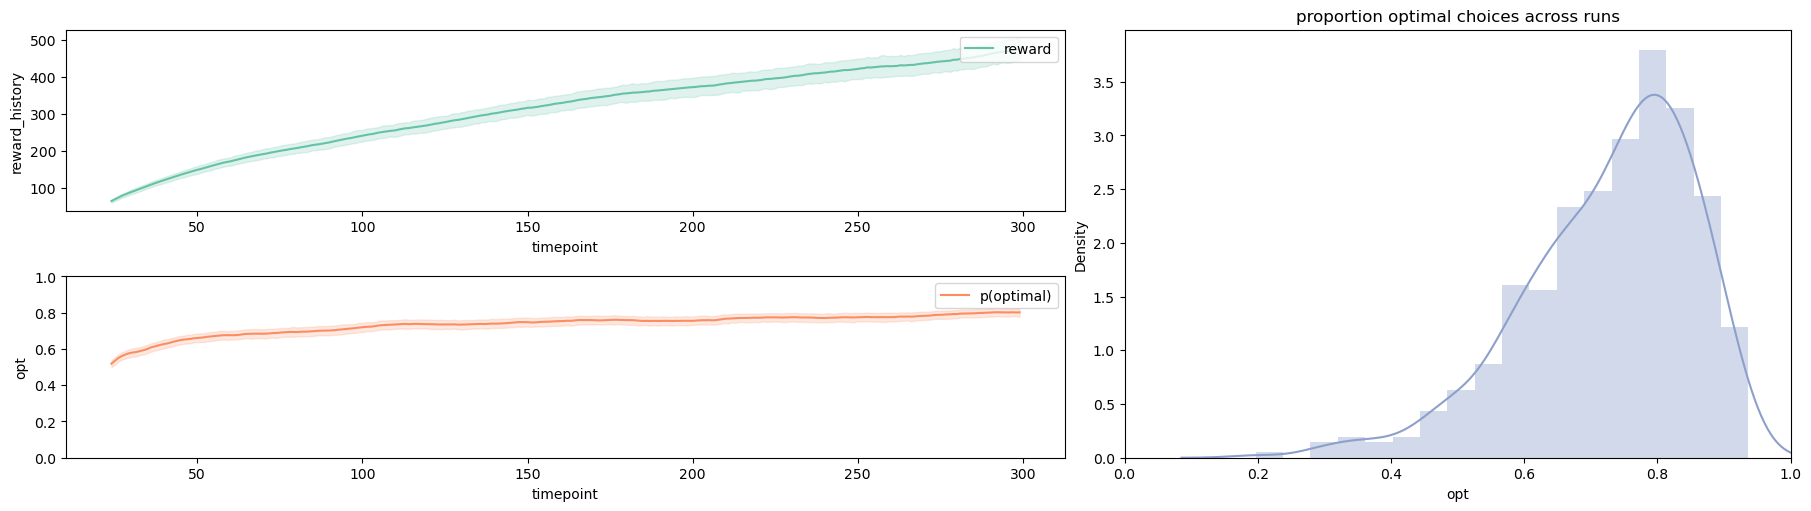

In [62]:
EPSILON = 0.1
ALPHA = 0.5

reward_history = []
opt_history = []
run_history = []
timestep = []

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = EpsilonGreedyAgentConstant(n_bandits, epsilon = 0.1, alpha=0.5)
    np.random.shuffle(bandit_means)  # randomize location of "best"
    bandit = KArmBanditRestless(n_bandits)
    for i in range(n_timesteps):  # for a certain number of time steps
        # Choose and Learn
        choice = agent.choose()  # let the agent choose
        reward, opt = bandit.step(choice)
        agent.learn(reward=reward, action=choice)
        
        # Record the returns
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)
# plot the results
sim_result_df = pd.DataFrame(
    {
        "run": run_history,
        "timepoint": timestep,
        "reward_history": reward_history,
        "opt": opt_history,
    }
)
plot_results(sim_result_df)

<div class="alert alert-warning">
<h3>EpsilonGreedyAgentConstant with Epsilon=0.1 Alpha=0.1 on Restless Bandit</h3>
</div>

C:\Users\liaof\AppData\Local\Temp\ipykernel_14132\1273946726.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


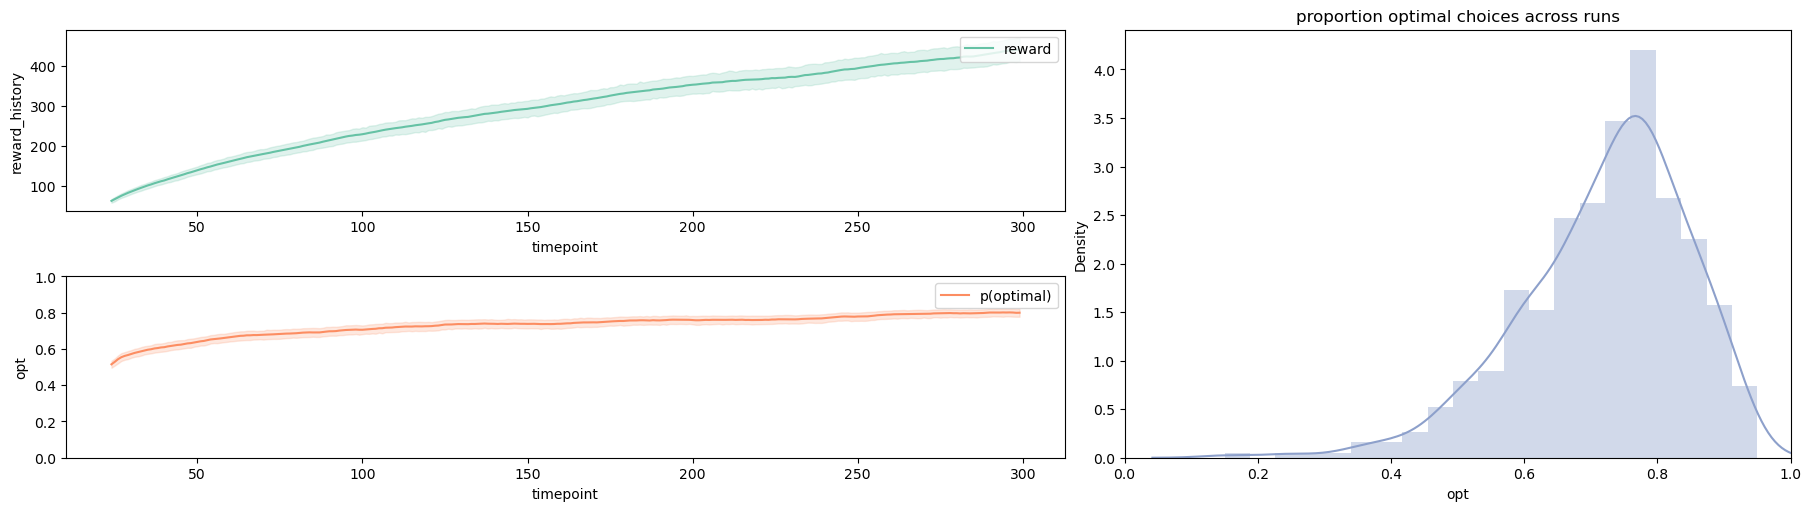

In [63]:
EPSILON = 0.1
ALPHA = 0.1

reward_history = []
opt_history = []
run_history = []
timestep = []

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = EpsilonGreedyAgentConstant(n_bandits, epsilon = 0.1, alpha=0.5)
    np.random.shuffle(bandit_means)  # randomize location of "best"
    bandit = KArmBanditRestless(n_bandits)
    for i in range(n_timesteps):  # for a certain number of time steps
        # Choose and Learn
        choice = agent.choose()  # let the agent choose
        reward, opt = bandit.step(choice)
        agent.learn(reward=reward, action=choice)
        
        # Record the returns
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)
# plot the results
sim_result_df = pd.DataFrame(
    {
        "run": run_history,
        "timepoint": timestep,
        "reward_history": reward_history,
        "opt": opt_history,
    }
)
plot_results(sim_result_df)

<div class="alert alert-warning">
<h3>EpsilonGreedyAgentConstant with Epsilon=0.1 Alpha=0.01 on Restless Bandit</h3>
</div>

C:\Users\liaof\AppData\Local\Temp\ipykernel_14132\1273946726.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


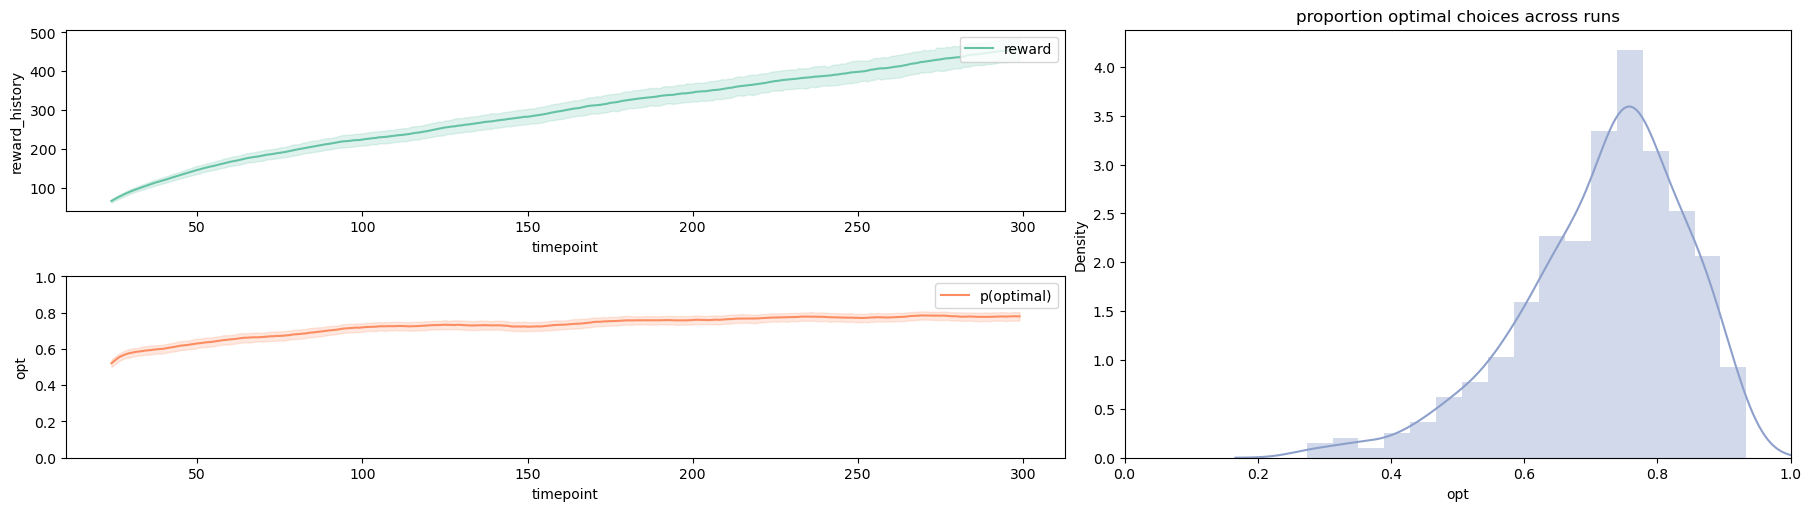

In [64]:
EPSILON = 0.1
ALPHA = 0.01

reward_history = []
opt_history = []
run_history = []
timestep = []

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = EpsilonGreedyAgentConstant(n_bandits, epsilon = 0.1, alpha=0.5)
    np.random.shuffle(bandit_means)  # randomize location of "best"
    bandit = KArmBanditRestless(n_bandits)
    for i in range(n_timesteps):  # for a certain number of time steps
        # Choose and Learn
        choice = agent.choose()  # let the agent choose
        reward, opt = bandit.step(choice)
        agent.learn(reward=reward, action=choice)
        
        # Record the returns
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)
# plot the results
sim_result_df = pd.DataFrame(
    {
        "run": run_history,
        "timepoint": timestep,
        "reward_history": reward_history,
        "opt": opt_history,
    }
)
plot_results(sim_result_df)

<div class="alert alert-warning">
<h3>EpsilonGreedyAgentConstant with Epsilon=0.1 Alpha=0.01 on Restless Bandit</h3>
</div>

C:\Users\liaof\AppData\Local\Temp\ipykernel_14132\1273946726.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


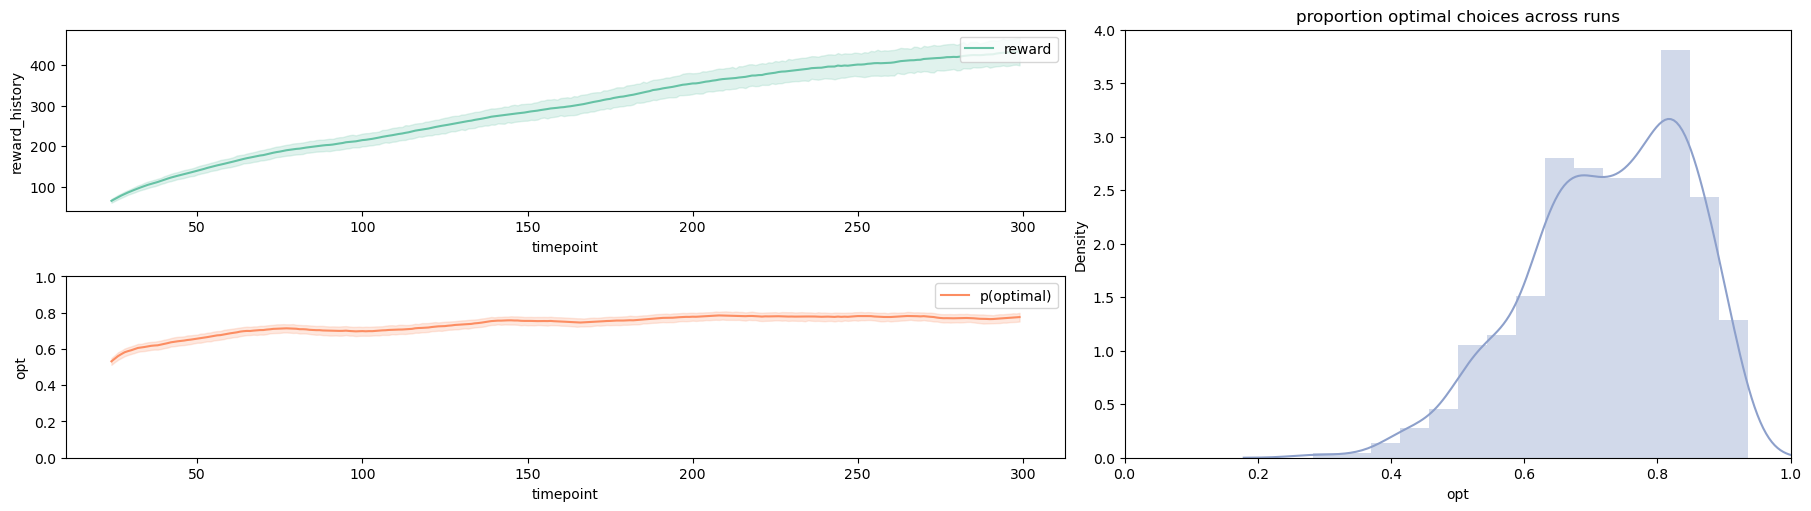

In [65]:
EPSILON = 0.1
ALPHA = 0.001

reward_history = []
opt_history = []
run_history = []
timestep = []

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = EpsilonGreedyAgentConstant(n_bandits, epsilon = 0.1, alpha=0.5)
    np.random.shuffle(bandit_means)  # randomize location of "best"
    bandit = KArmBanditRestless(n_bandits)
    for i in range(n_timesteps):  # for a certain number of time steps
        # Choose and Learn
        choice = agent.choose()  # let the agent choose
        reward, opt = bandit.step(choice)
        agent.learn(reward=reward, action=choice)
        
        # Record the returns
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)
# plot the results
sim_result_df = pd.DataFrame(
    {
        "run": run_history,
        "timepoint": timestep,
        "reward_history": reward_history,
        "opt": opt_history,
    }
)
plot_results(sim_result_df)

<div class="alert alert-success" role="alert">
<h3> Problem 7 (15 points) </h3><br>
 
For this problem, we return to the grid world task we considered in Part A.  Specifically, you should combine the ideas about explore-exploit and incremental learning of q-values to implement a temporal-difference solution the to grid world problem you explored in Part A of the homework.  You can reuse the code from that notebook in building your solution.  This solution should also obtain similar results to the policy-iteration and monte-carlo versions you explored, but is learned more incrementally and online.

The basic setup of the GridWorld environment is provided again for you below.
Your solution to this problem should involve modifications to the solution to
the Monte-Carlo problems in Part A. In particular, instead of waiting until a
particular episode ends to update the values of the Q-values, use the
Q-learning equation to incrementally updates these values as an episode
unfolds. To balance exploration and exploitation try any of the methods you
developed in the earlier parts of this assignment.

As a reminder the question for updating the Q values in Q-learning is as
follows:

$Q(s,a) = Q(s,a) + \alpha [r +\gamma max_{a'} Q(s',a') - Q(s,a)] $

The pseudo code for this algorithm is:

```
Initialize, for all $s \in S$, $a \in A(s)$:
    $Q(s,a)$ <- arbitrary

Repeat many times (for each episode):
    a) Initialize $s$ at the start state
    b) Repeat
        1. Choose action $a$ from $s$ using policy dervived from Q values in that state (e.g., SoftMax)
        2. Take action $a$, observe $r$, $s'$
        3. Update $Q(s,a)$
           Find max Q(s',a') over all action a' in state s'
           $Q(s,a) = Q(s,a) + \alpha [r + \gamma max Q(s',a') - Q(s,a)]$
           $s$ <- $s'$
       Until $s$ is the goal state
```

</div>


In [28]:
# import the gridworld library
import numpy as np
import random
import math
import statistics
from copy import deepcopy
from IPython.display import display, Markdown, Latex, HTML
from gridworld import GridWorld, random_policy

In [29]:
gridworld = [
    ["o", "o", "o", "o", "o", "o", "o", "x", "g"],
    ["o", "x", "x", "o", "x", "x", "o", "x", "o"],
    ["o", "x", "x", "o", "x", "x", "o", "x", "o"],
    ["o", "x", "x", "o", "x", "x", "o", "o", "o"],
    ["o", "x", "x", "o", "x", "x", "x", "o", "o"],
    ["s", "o", "o", "o", "o", "o", "o", "o", "x"],
]  # the problem described above, 'x' is a wall, 's' is start, 'g' is goal, and 'o' is a normal room


mygrid = GridWorld(gridworld)
mygrid.raw_print()  # print out the grid world
mygrid.index_print()  # print out the indicies of each state
mygrid.coord_print()  # print out the coordinates of each state (helpful in your code)

# define the rewards as a hash table
rewards = {}

# mygrid.transitions contains all the pairwise state-state transitions allowed in the grid
# for each state transition intialize the reward to zero
for start_state in mygrid.transitions:
    for action in mygrid.transitions[start_state].keys():
        next_state = mygrid.transitions[start_state][action]
        rewards[str([start_state, action, next_state])] = 0.0

# now set the reward for moving up into state 8 (the goal state) to +10
rewards[str([17, "up", 8])] = 10

# now set the penalty for walking off the edge of the grid and returning to state 45 (the start state)
for i in [0, 1, 2, 3, 4, 5, 6, 7]:
    rewards[str([i, "up", 45])] = -1
for i in [0, 9, 18, 27, 36, 45]:
    rewards[str([i, "left", 45])] = -1
for i in [45, 46, 47, 48, 49, 50, 51, 52, 53]:
    rewards[str([i, "down", 45])] = -1
for i in [8, 17, 26, 35, 44, 53]:
    rewards[str([i, "right", 45])] = -1

## Welcome to your new Grid World!

**Raw World Layout**

**Indexes of each grid location as an id number**

**Indexes of each grid location as a tuple**

<div class="alert alert-info" role="alert">
  
  The following code sets up the major things you need to track.  Note that unlike in the Monte Carlo solution you do not need a separate accounting of the returns as you are updating those to the Q-values directly.
  
  Also you shouldn't need to update the policy table until you have run many episodes through the maze.  The final update to the `policy_table` should just to be to print out your final greedy solution and compare it to the solutions you obtained in Part A.
 
</div>


In [31]:
starting_state = 45
goal_state = 8  # terminate the MC roll out when you get to this state
max_depth = 100

GAMMA = 0.9
EPSILON = 0.2
TAO = 1
ALPHA = 0.1

ACTION_ARR = np.array(["up", "right", "down", "left"])
ITERATIONS = 200000  # this may need to be 100,000 or more!
PRINT_EVERY = 40000  # how often to print out our progress
random.seed(5000)  # try multiple random seed to verify your code works

# set up initial data strucutres that might be useful for you
# q(s,a) - the q-values for each action in each state
def zero_q_values():
    qvals = {"up": 0.0, "right": 0.0, "down": 0.0, "left": 0.0}
    return qvals


q_value_table = [
    [zero_q_values() for i in range(mygrid.ncols)] for j in range(mygrid.nrows)
]

# pi - the policy table
policy_table = [
    [random_policy() for i in range(mygrid.ncols)] for j in range(mygrid.nrows)
]
display(Markdown("**Initial (randomized) policy**"))
mygrid.pretty_print_policy_table(policy_table)

# this is a helper function that will take a set of q-values and convert them into a greedy decision strategy
def be_greedy(q_values):
    if len(q_values) == 0:
        return {}

    keys = list(q_values.keys())
    vals = [q_values[i] for i in keys]
    maxqs = [i for i, x in enumerate(vals) if x == max(vals)]
    if len(maxqs) > 1:
        pos = random.choice(maxqs)
    else:
        pos = maxqs[0]
    policy = deepcopy(q_values)
    for i in policy.keys():
        policy[i] = 0.0
    policy[keys[pos]] = 1.0
    return policy

for i in tqdm(range(ITERATIONS)):  
    # you probably need to take many, many steps here and it make take some time to run
    # instead of always starting at the start state, this algorithm will use the concept of an
    # "exploring start" so that it starts in a random valid state
    # this can help a lot
    
    # select and exploring start state
    cur_state = starting_state
    
    # Repeat
    for depth in range(max_depth):
    # 1. Choose action a from s using policy dervived from Q values in that state (e.g., SoftMax)
        cur_sx, cur_sy = mygrid.index_to_coord(cur_state)
        if random.random() < epsilon:
            cur_Q = q_value_table[cur_sx][cur_sy]
            softmax_probs = np.zeros(4)
            sum_exp_Q = 0.0
            for a_idx, a in enumerate(ACTION_ARR):
                exp_Q_a = np.exp(cur_Q[a])/TAO
                softmax_probs[a_idx] = exp_Q_a
                
                sum_exp_Q += exp_Q_a
            if sum_exp_Q == 0.0:
                softmax_probs = [1/4 for a in ACTION_ARR]
            else:
                softmax_probs = softmax_probs/sum_exp_Q
            
            chosen_a = np.random.choice(ACTION_ARR, 1, p=softmax_probs)[0]
        else:
            if policy_table[cur_sx][cur_sy]["up"] == 1.0:
                chosen_a = "up"
            elif policy_table[cur_sx][cur_sy]["right"] == 1.0:
                chosen_a = "right"
            elif policy_table[cur_sx][cur_sy]["down"] == 1.0:
                chosen_a = "down"
            elif policy_table[cur_sx][cur_sy]["left"] == 1.0:
                chosen_a = "left"
    
    # 2. Take action a, observe r, s'
        match chosen_a:
            case "up":
                new_state = mygrid.up(cur_state)
            case "right":
                new_state = mygrid.right(cur_state)
            case "down":
                new_state = mygrid.down(cur_state)
            case "left":
                new_state = mygrid.left(cur_state)
            
        r = rewards[str([cur_state, chosen_a, new_state])]
        
    # 3. Update Q(s,a)
        # Find max Q(s',a') over all action a' in state s'
        new_sx, new_sy = mygrid.index_to_coord(new_state)
        new_Q = q_value_table[new_sx][new_sy]
        max_new_Q_a = max(new_Q.values())
        
        # Q(s,a) = Q(s,a) + \alpha [r + \gamma max Q(s',a') - Q(s,a)]
        q_value_table[cur_sx][cur_sy][chosen_a] += ALPHA * (r + GAMMA * max_new_Q_a - 
                                                            q_value_table[cur_sx][cur_sy][chosen_a])
        # s <- s'
        cur_state = new_state
        
        # Until $s$ is the goal state
        if cur_state == goal_state:
            break

    # improve policy
    for sx in range(len(q_value_table)):
        for sy in range(len(q_value_table[sx])):
            policy_table[sx][sy] = be_greedy(q_value_table[sx][sy])

    if i % PRINT_EVERY == 0:
        display(Markdown(f"**Improved policy interation {i}**"))
        mygrid.pretty_print_policy_table(policy_table)

display(Markdown("**Improved policy**"))
mygrid.pretty_print_policy_table(policy_table)

**Initial (randomized) policy**

  0%|          | 0/200000 [00:00<?, ?it/s]

**Improved policy interation 0**

 20%|█▉        | 39747/200000 [00:16<01:04, 2473.34it/s]

**Improved policy interation 40000**

 40%|███▉      | 79888/200000 [00:31<00:47, 2505.94it/s]

**Improved policy interation 80000**

 60%|█████▉    | 119797/200000 [00:47<00:31, 2526.66it/s]

**Improved policy interation 120000**

 80%|███████▉  | 159972/200000 [01:03<00:16, 2479.18it/s]

**Improved policy interation 160000**

100%|██████████| 200000/200000 [01:20<00:00, 2498.73it/s]


**Improved policy**

# Turning in homework

When you are finished with this notebook. Save your work in order to turn it
in. To do this select _File_->_Download As..._->_HTML_.

<img src="images/save-pdf.png" width="300">

You can turn in your assignments using Gradescope for the course (available on
https://home.nyu.edu). **Make sure you complete all parts (A and B) of this
homework.**
